## Host Ecosystem Analysis: Does Scale Compromise Quality?

Thessaloniki's short-term rental market has grown rapidly, raising questions about whether professional operators enhance or diminish the guest experience. Understanding host ecosystem dynamics is crucial for evidence-based tourism policy.

### Research Questions
1. Do multi-property hosts achieve different guest engagement patterns than smaller operators?
2. Does the current host ecosystem structure benefit the rental market?
3. Is there a "sweet spot" in host portfolio size for optimal performance?

### Host Categorization Framework

| Category | Listings | Profile |
|----------|----------|---------|
| **Individual** | 1 | Casual/occasional hosts, often sharing personal space |
| **Small Multi** | 2-3 | Semi-professional, transitioning to STR business |
| **Medium Multi** | 4-10 | Professional operators, dedicated STR management |
| **Large Multi** | 11+ | Commercial/corporate operators, scaled operations |

### Key Finding Preview
> *Mid-scale professional hosts (2-10 listings) achieve the optimal balance of operational efficiency and guest experience quality. Large commercial operators (11+ listings) show signs of "scale without soul" — higher market share but lower quality scores, suggesting a volume-over-quality approach.*

1. INTRODUCTION
   - H3 hypothesis statement
   - Why this matters for Thessaloniki
   
2. HOST CATEGORIZATION
   - Rationale for 4-tier system
   - Distribution visualization (how many hosts in each tier)
   - Market concentration insight (what % of listings do Large Multi control?)

3. AUTOMATED EDA (collapsed/silent)
   - Run comprehensive EDA
   - Note: "Full output available in appendix/report"

4. KEY FINDINGS BY THEME

   4.1 Market Entry & Tenure
       - Listing age finding + visual
       - Insight: "Large operators are newer entrants"
   
   4.2 Financial Performance  
       - Revenue finding + visual + Kruskal-Wallis
       - Occupancy finding + visual
       - Insight: "Scale correlates with revenue but not proportionally"
   
   4.3 Quality & Guest Experience
       - Review scores finding + visual + statistical test
       - Insight: "Quality declines with scale"
   
   4.4 Operational Behavior
       - Acceptance rate finding (brief mention)
       - Insight: "Volume over selectivity"
   
   4.5 The Superhost Magnifier (CLIMAX)
       - Superhost distribution by category
       - Two-way analysis summary table
       - Key insight: "Superhost status matters more for small operators"
       - The "greedy operator" problem

5. SYNTHESIS & RECOMMENDATIONS
   - Summary table of all findings
   - Policy implications
   - Limitations

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.insert(0, str(Path.cwd().parent))
from scripts.eda_functions import (
    analyze_numeric_variable,
    analyze_categorical_variable,
    analyze_categorical_numerical,
    analyze_categorical_categorical
    )

In [ ]:
data_path = Path.cwd().parent / "data" / "processed"
df = pd.read_parquet(data_path / "listings_regular_license.parquet", engine="pyarrow")
pd.set_option('display.float_format', '{:,.2f}'.format)
df.shape

(4124, 54)

In [ ]:
# Set global style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")  # or "husl", "muted", "pastel", "deep", "colorblind"

# For matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("Set2"))

In [ ]:
# Create host_cat column based on host_total_listings_count
def categorize_host_count(count):
    if pd.isna(count):
        return None
    elif count == 1:
        return "Individual (1)"
    elif count <= 3:
        return "Small Multi (2-3)"
    elif count <= 10:
        return "Medium Multi (4-10)"
    else:
        return "Large Multi (11+)"

df["host_cat"] = df["host_total_listings_count"].apply(categorize_host_count)

# Display the distribution
df["host_cat"].value_counts(dropna=False)

host_cat
Large Multi (11+)      1480
Individual (1)          948
Medium Multi (4-10)     755
Small Multi (2-3)       734
None                    207
Name: count, dtype: int64

In [ ]:
# Host category distribution
df["Host_Category"].value_counts(normalize=True).round(2)

Host_Category
Large Multi (4+)    0.57
Individual (1)      0.24
Small Multi (2-3)   0.19
Name: proportion, dtype: float64

### Nan values imputation in `Host_Category`

In [ ]:
nan_df = df.loc[df["Host_Category"] == "nan"]
nan_df.shape

(180, 55)

In [ ]:
nan_df["host_id"].nunique()

76

In [ ]:
# Take a look at the most frequent hosts in the nan dataset
nan_df["host_id"].value_counts().head(5)

host_id
HOST_7C4743    26
HOST_4A3473    17
HOST_B12F22    13
HOST_3F90DF    13
HOST_9E66ED     9
Name: count, dtype: int64

**Note:** There seem to be plenty of listings with missing host data for some hosts. We will try to impute these values based on the number of listings each host has.

In [ ]:
# Count occurrences of each host_id from nan_df in the full df
host_counts = df.loc[df["host_id"].isin(nan_df["host_id"]), "host_id"].value_counts()

# Map counts to categories
def categorize_host(count):
    if count == 1:
        return "Individual (1)"
    elif count <= 3:
        return "Small Multi (2-3)"
    elif count <= 10:
        return "Medium Multi (4-10)"
    else:
        return "Large Multi (11+)"

host_category_map = host_counts.apply(categorize_host)

# Update Host_Category for these hosts
df.loc[df["host_id"].isin(nan_df["host_id"]), "host_cat"] = df["host_id"].map(host_category_map)

In [ ]:
df["host_cat"].value_counts(normalize=True).round(2)

host_cat
Large Multi (11+)     0.38
Individual (1)        0.24
Medium Multi (4-10)   0.19
Small Multi (2-3)     0.19
Name: proportion, dtype: float64

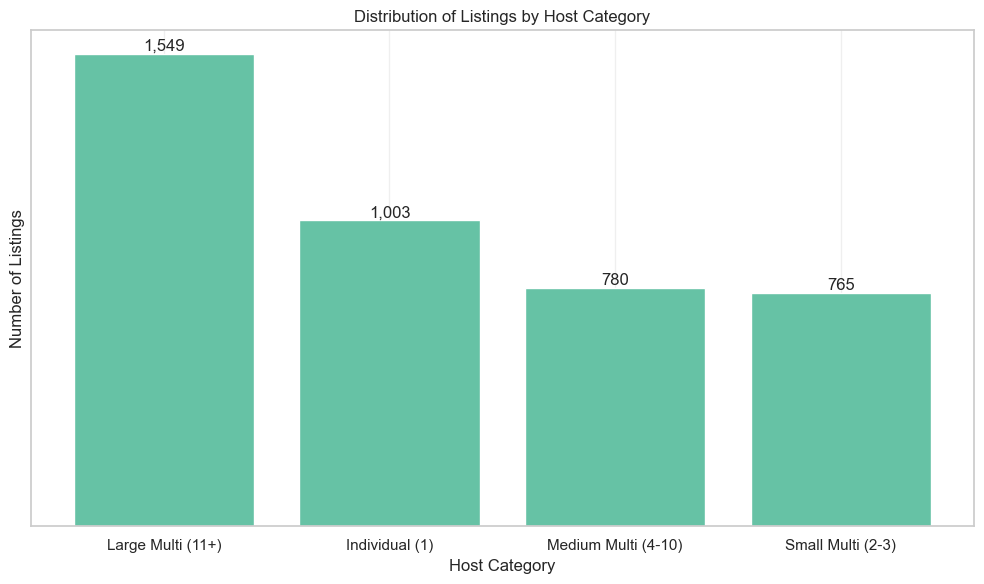

In [ ]:
# Bar chart for Host Category distribution
host_category_counts = df["host_cat"].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(host_category_counts.index, host_category_counts.values)
plt.xlabel('Host Category')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listings by Host Category')
plt.xticks(rotation=0)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

ax = plt.gca()
ax.set_yticks([])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df["host_total_listings_count"].describe()

count   3,917.00
mean       60.65
std       127.03
min         1.00
25%         2.00
50%         5.00
75%        33.00
max     1,038.00
Name: host_total_listings_count, dtype: Float64

In [ ]:
df["host_total_listings_count"].mode()

0    1
Name: host_total_listings_count, dtype: Int16

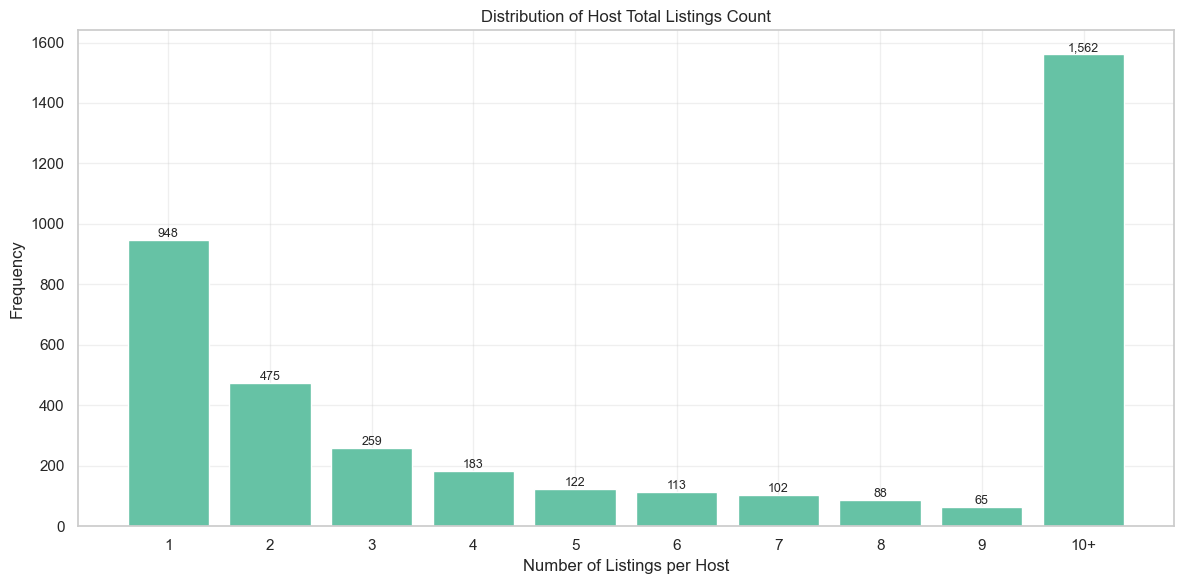

In [ ]:
# Create binned histogram for host_total_listings_count
bins = list(range(1, 11)) + [df["host_total_listings_count"].max() + 1]
labels = [str(i) for i in range(1, 10)] + ["10+"]

df["listings_bin"] = pd.cut(df["host_total_listings_count"], bins=bins, labels=labels, right=False)
bin_counts = df["listings_bin"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(bin_counts.index, bin_counts.values)
plt.xlabel('Number of Listings per Host')
plt.ylabel('Frequency')
plt.title('Distribution of Host Total Listings Count')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Clean up temporary column
df.drop(columns=["listings_bin"], inplace=True)

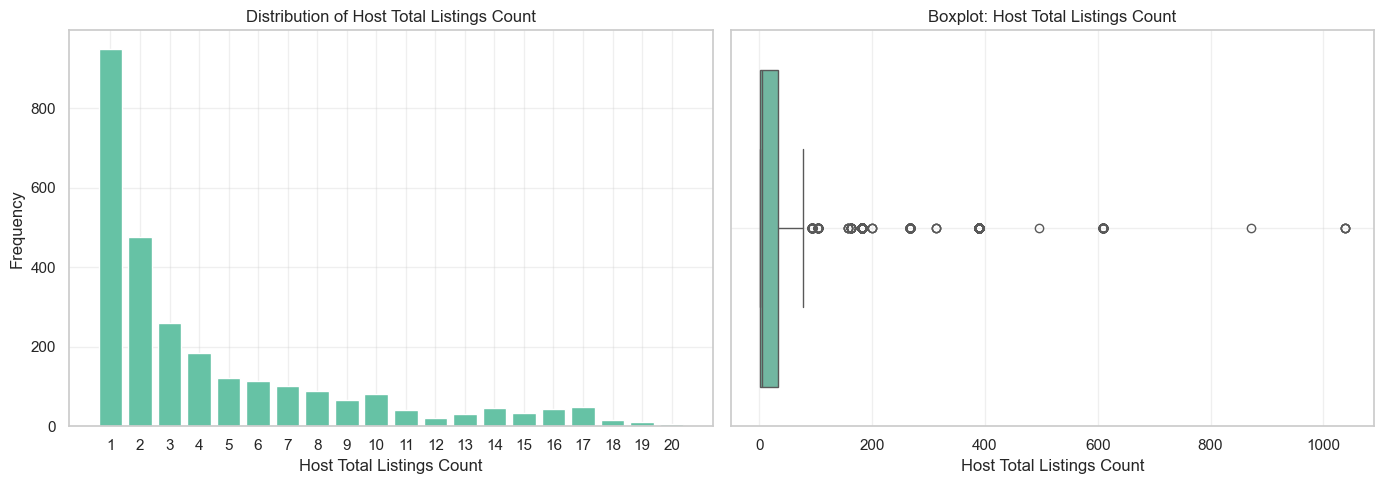

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
listing_counts = df["host_total_listings_count"].value_counts().sort_index().head(20)
axes[0].bar(listing_counts.index.astype(str), listing_counts.values)
axes[0].set_xlabel('Host Total Listings Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Host Total Listings Count')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3)

# Boxplot
sns.boxplot(x=df["host_total_listings_count"], ax=axes[1])
axes[1].set_xlabel('Host Total Listings Count')
axes[1].set_title('Boxplot: Host Total Listings Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Comment:** The distribution of `host_total_listings_count` seems to be highly right-skewed. While most hosts have only 1 listing, there are quite a few extreme outliers with hundreds of listings.

In [ ]:
# Market concentration analysis: What % of listings do top hosts control?

# Count listings per host in our dataset
host_listing_counts = df.groupby('host_id').size().sort_values(ascending=False)

# Total listings in dataset
total_listings = len(df)

# Top 10 hosts
top_10_hosts = host_listing_counts.head(10)
top_10_share = top_10_hosts.sum() / total_listings * 100

# Top 1%, 5%, 10% of hosts
n_hosts = host_listing_counts.nunique()
top_1pct = host_listing_counts.head(max(1, int(n_hosts * 0.01))).sum() / total_listings * 100
top_5pct = host_listing_counts.head(max(1, int(n_hosts * 0.05))).sum() / total_listings * 100
top_10pct = host_listing_counts.head(max(1, int(n_hosts * 0.10))).sum() / total_listings * 100

print("=" * 50)
print("MARKET CONCENTRATION ANALYSIS")
print("=" * 50)
print(f"\nTotal listings: {total_listings:,}")
print(f"Total unique hosts: {n_hosts:,}")
print(f"Average listings per host: {total_listings/n_hosts:.2f}")

print(f"\n📊 Top Host Concentration:")
print(f"   Top 10 hosts control: {top_10_share:.1f}% of listings ({top_10_hosts.sum():,} listings)")
print(f"   Top 1% of hosts ({int(n_hosts * 0.01):,}) control: {top_1pct:.1f}% of listings")
print(f"   Top 5% of hosts ({int(n_hosts * 0.05):,}) control: {top_5pct:.1f}% of listings")
print(f"   Top 10% of hosts ({int(n_hosts * 0.10):,}) control: {top_10pct:.1f}% of listings")

print(f"\n🏆 Top 10 Hosts by Listing Count:")
for i, (host, count) in enumerate(top_10_hosts.items(), 1):
    pct = count / total_listings * 100
    print(f"   {i}. {host}: {count} listings ({pct:.1f}%)")

<hr>

### Variables to check against `Host_Category`

In [ ]:
variables = [
    "listing_age_years",
    "estimated_revenue_l365d",
    "estimated_occupancy_l365d",
    "review_scores_rating",
    "host_is_superhost",
    "host_acceptance_rate"
]

DESCRIPTIVE STATISTICS: listing_age_years

Central Tendency:
  Mean:           2.78
  Median:         1.89
  Mode:           0.6543463381245722

Dispersion:
  Std Dev:        2.51
  Variance:       6.31
  Range:          13.06
  IQR:            3.18

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       0.82
  Q2 (50%):       1.89
  Q3 (75%):       4.00
  Max (100%):     13.06

Shape:
  Skewness:       1.070
  Kurtosis:       0.223

Sample Size:
  Valid:          4124
  Missing:        0
  Total:          4124


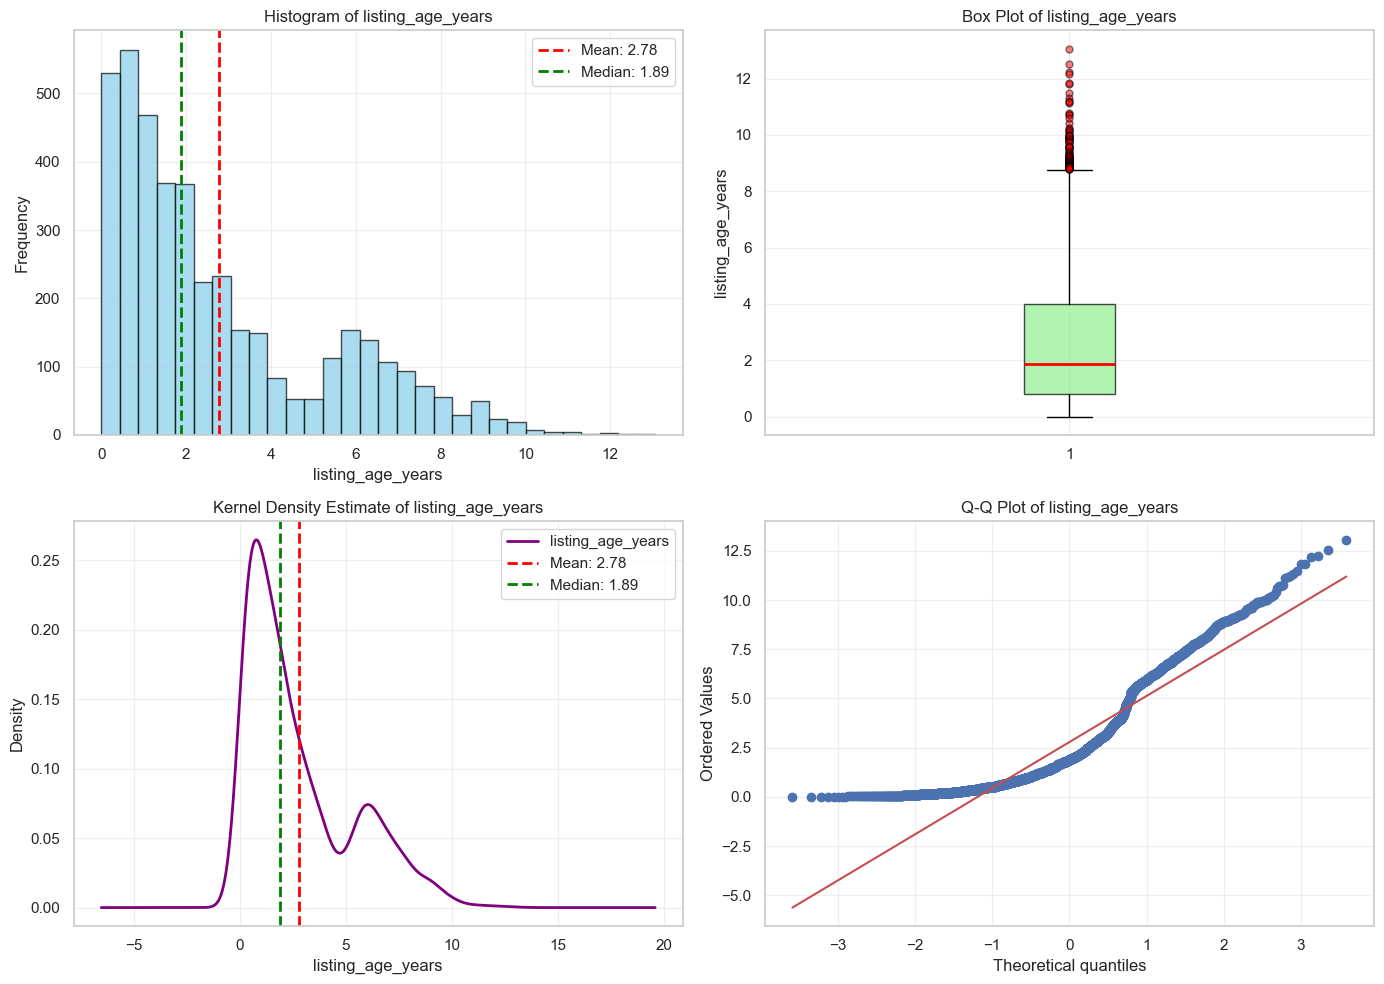

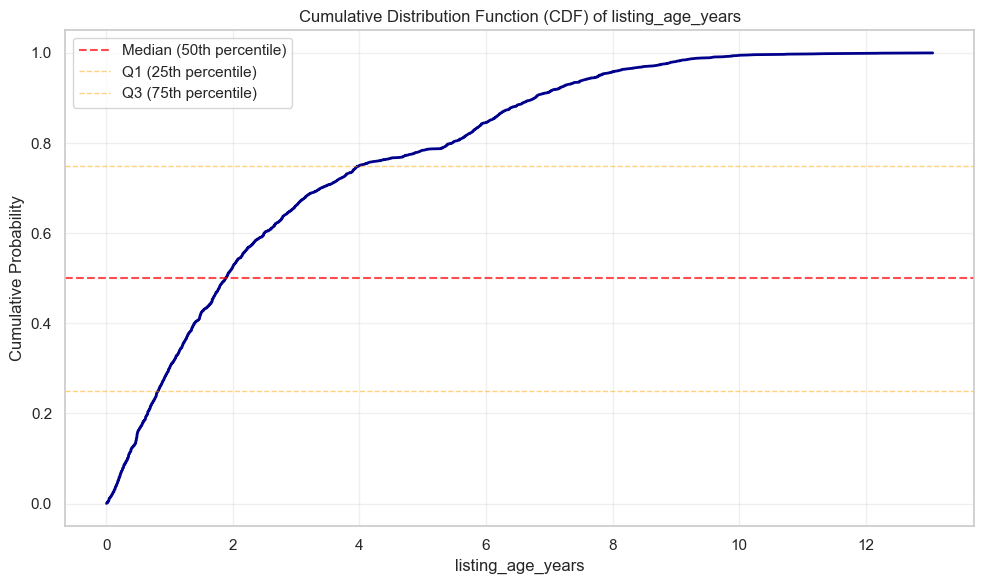

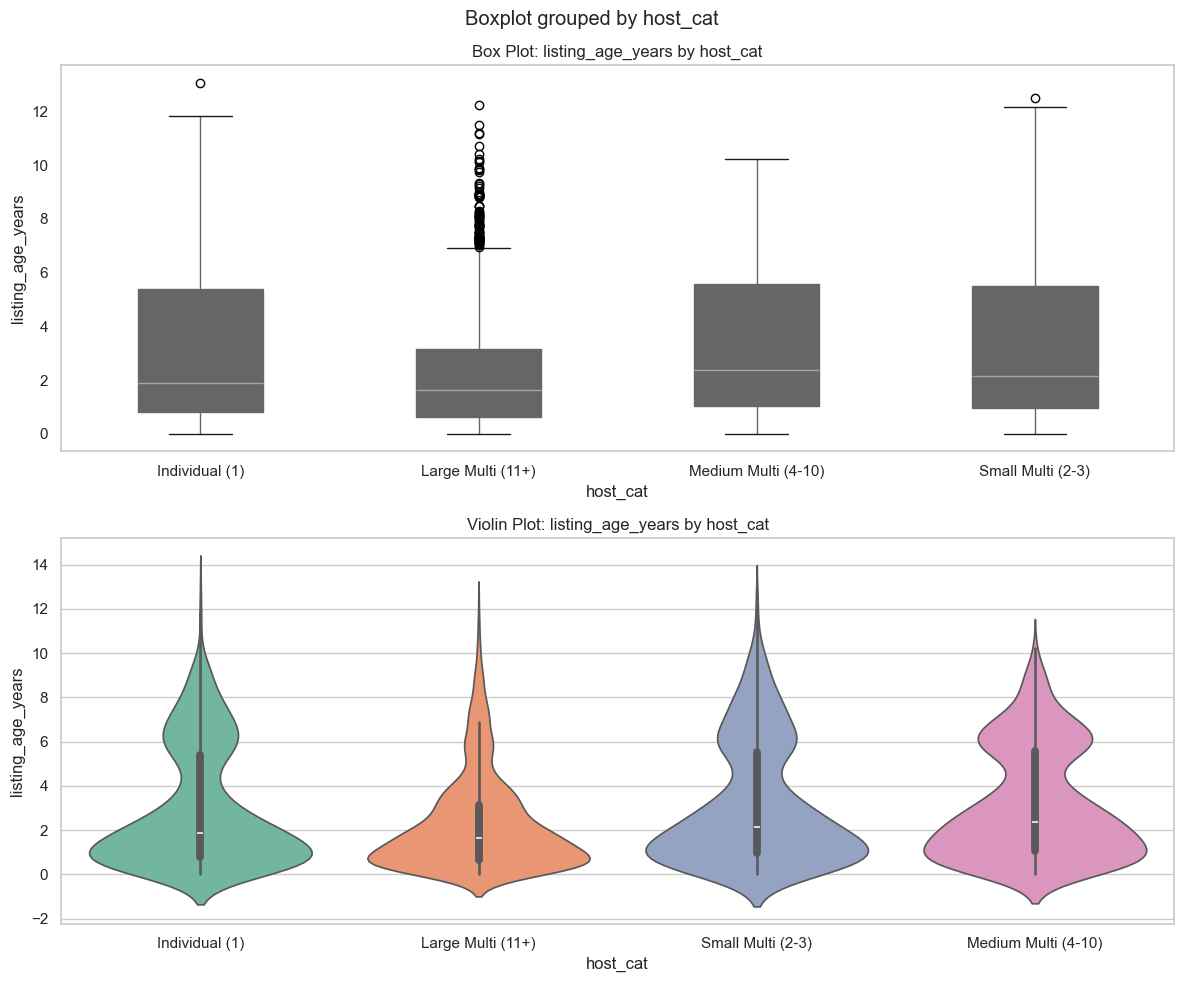

ONE-WAY ANOVA: listing_age_years by host_cat

Descriptive Statistics by Group:

  host_cat = Individual (1):
    N:      1003
    Mean:   2.9731
    Median: 1.8864
    Std:    2.6991
    Min:    0.0027
    Max:    13.0595

  host_cat = Large Multi (11+):
    N:      1549
    Mean:   2.2887
    Median: 1.6235
    Std:    2.1714
    Min:    0.0055
    Max:    12.2409

  host_cat = Small Multi (2-3):
    N:      765
    Mean:   3.1555
    Median: 2.1492
    Std:    2.7498
    Min:    0.0110
    Max:    12.5175

  host_cat = Medium Multi (4-10):
    N:      780
    Mean:   3.1556
    Median: 2.3819
    Std:    2.5049
    Min:    0.0164
    Max:    10.2204

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      33.9784
  P-value:             0.000000
  Eta-squared (η²):    0.024
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_cat has a significant effect on listing_age_years. Small e

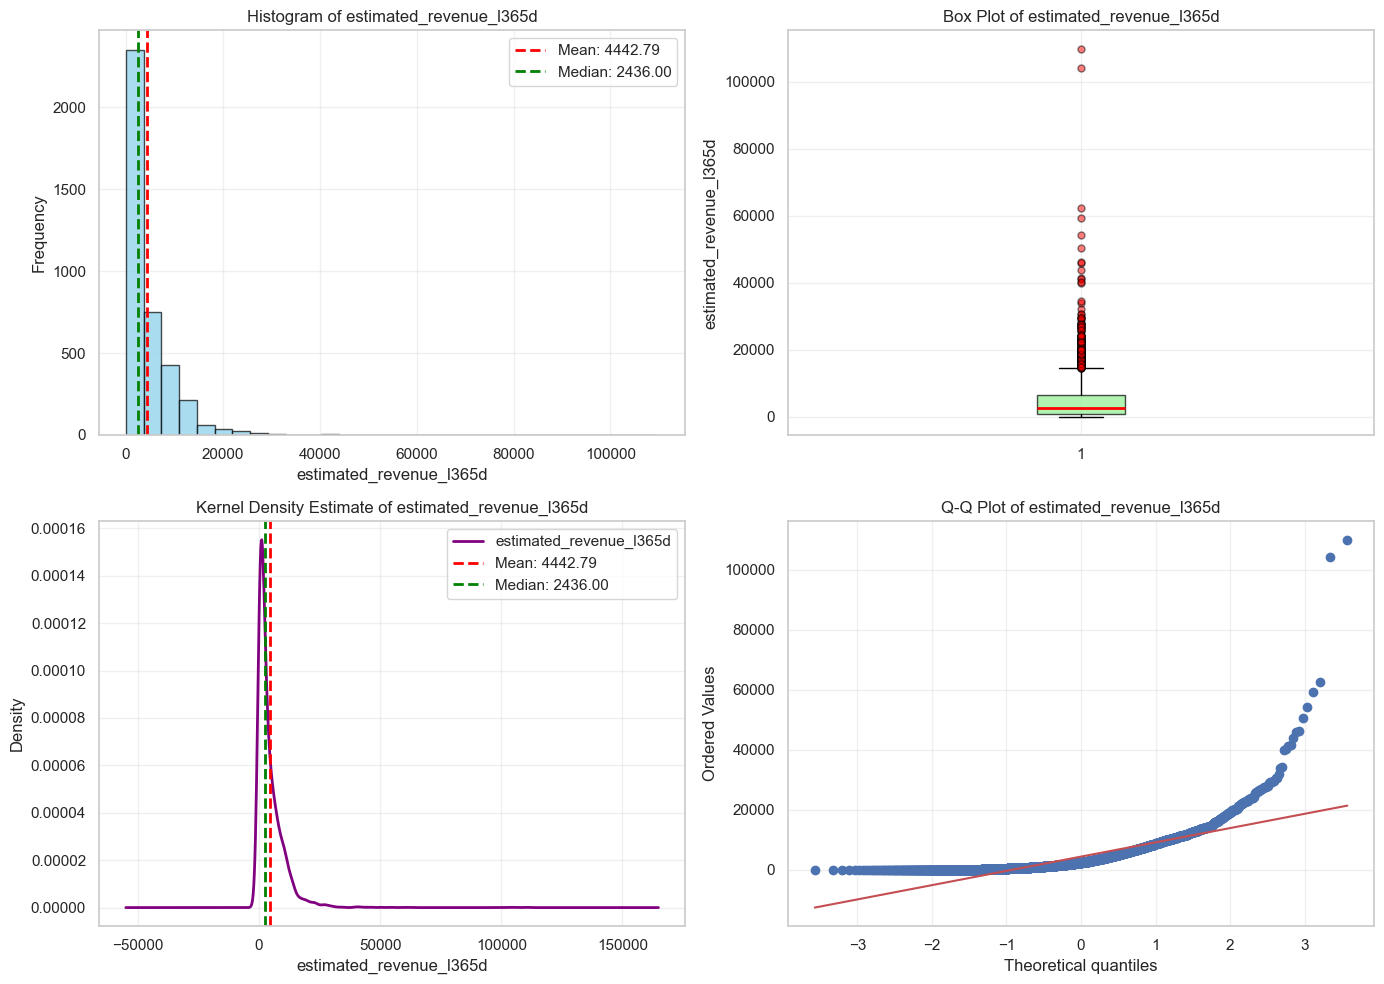

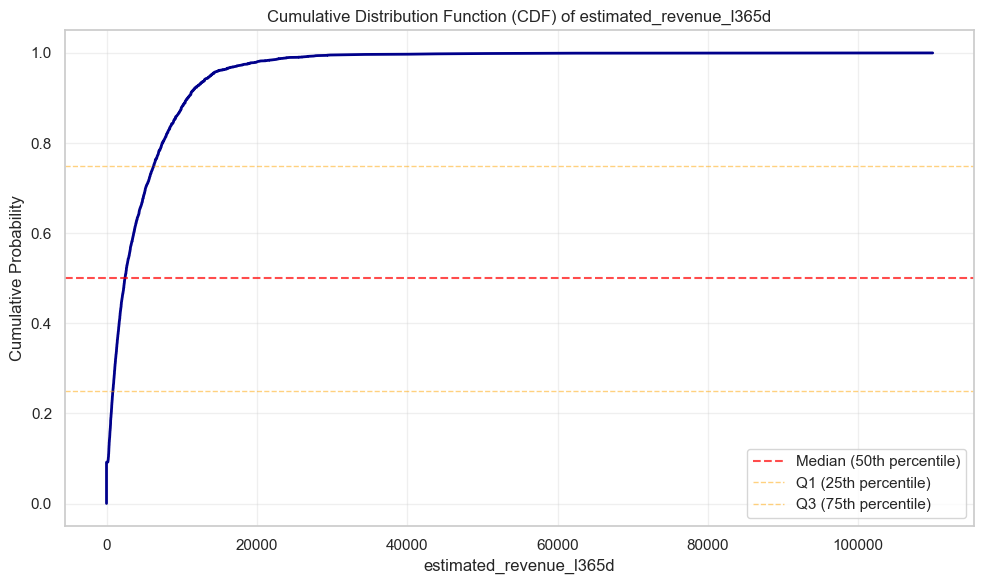

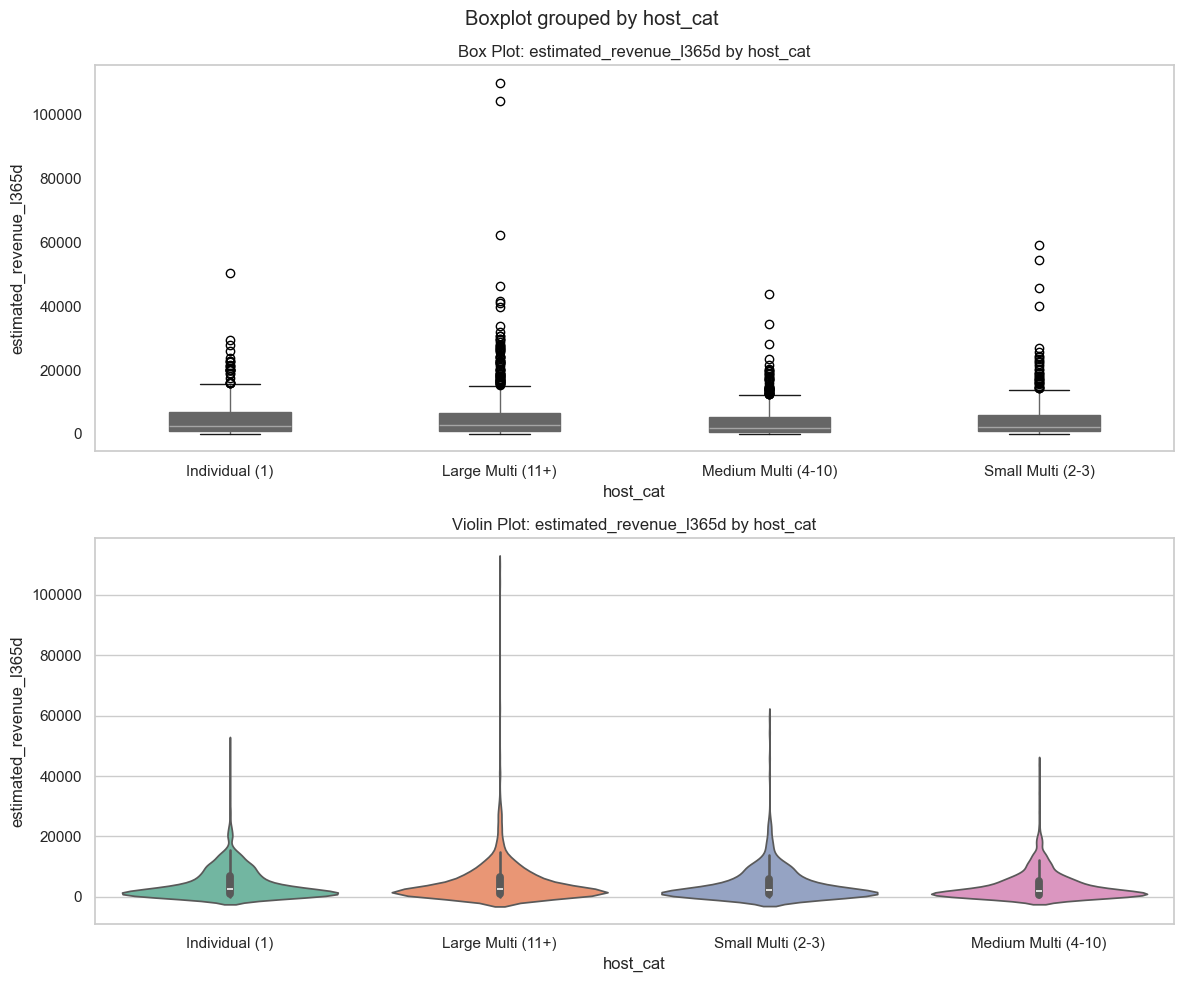

ONE-WAY ANOVA: estimated_revenue_l365d by host_cat

Descriptive Statistics by Group:

  host_cat = Individual (1):
    N:      946
    Mean:   4437.3446
    Median: 2592.0000
    Std:    4954.4437
    Min:    0.0000
    Max:    50430.0000

  host_cat = Large Multi (11+):
    N:      1472
    Mean:   4878.1413
    Median: 2640.0000
    Std:    6897.6296
    Min:    0.0000
    Max:    109896.0000

  host_cat = Small Multi (2-3):
    N:      727
    Mean:   4271.9739
    Median: 2220.0000
    Std:    5767.1019
    Min:    0.0000
    Max:    59280.0000

  host_cat = Medium Multi (4-10):
    N:      737
    Mean:   3769.5156
    Median: 1980.0000
    Std:    4675.1146
    Min:    0.0000
    Max:    43836.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      6.1453
  P-value:             0.000365
  Eta-squared (η²):    0.005
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000365). host_

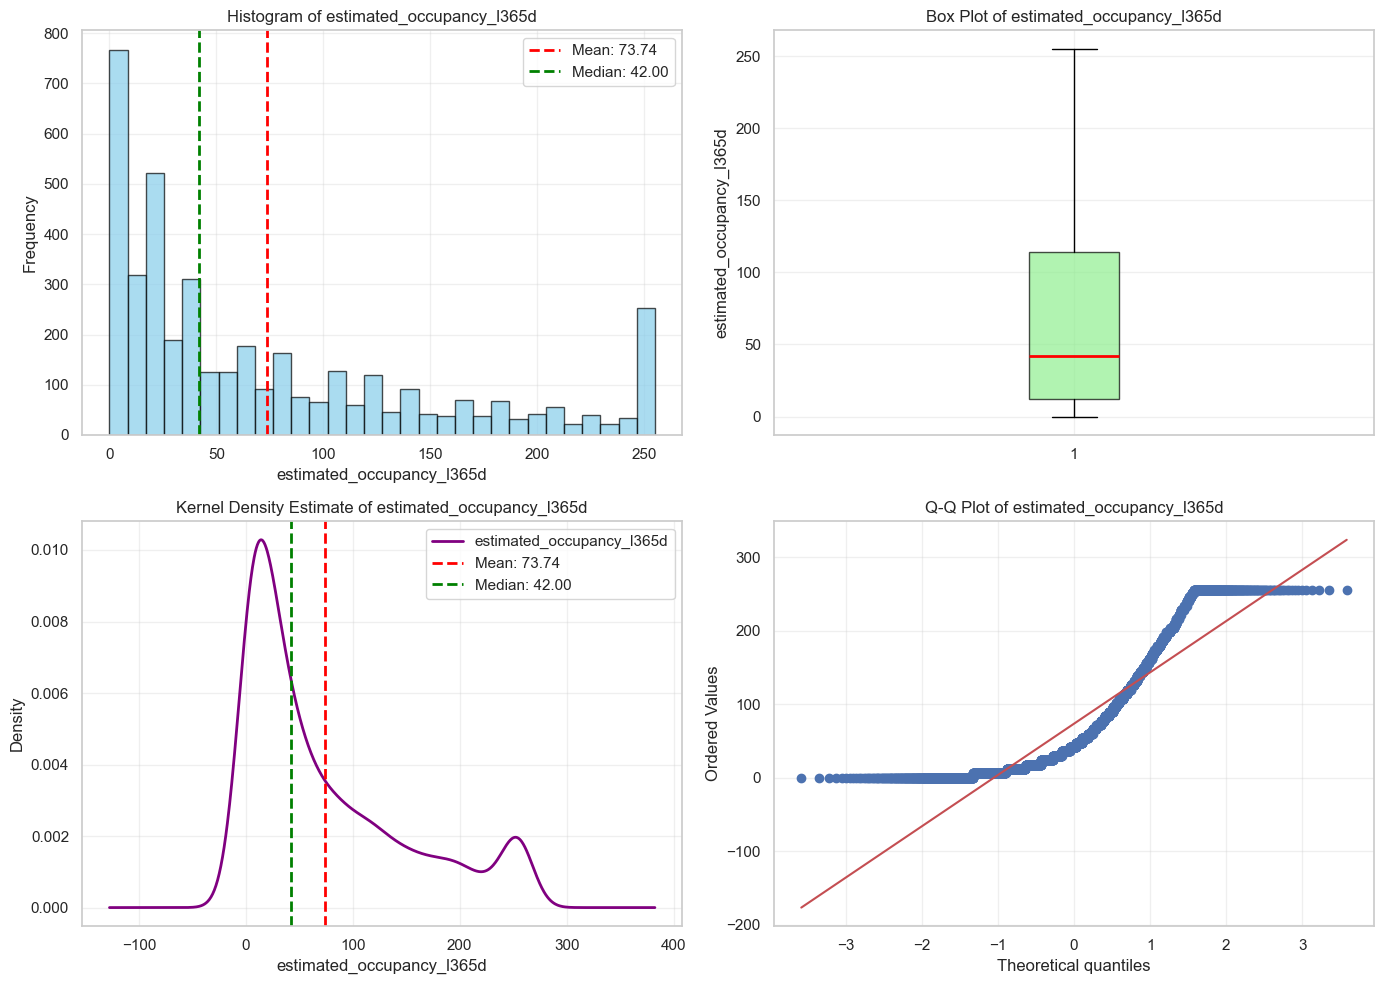

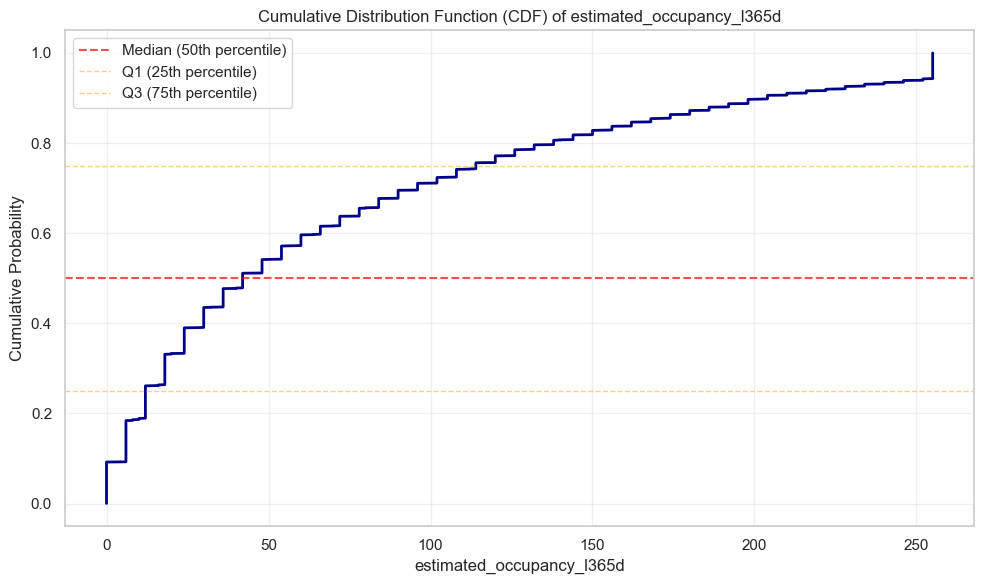

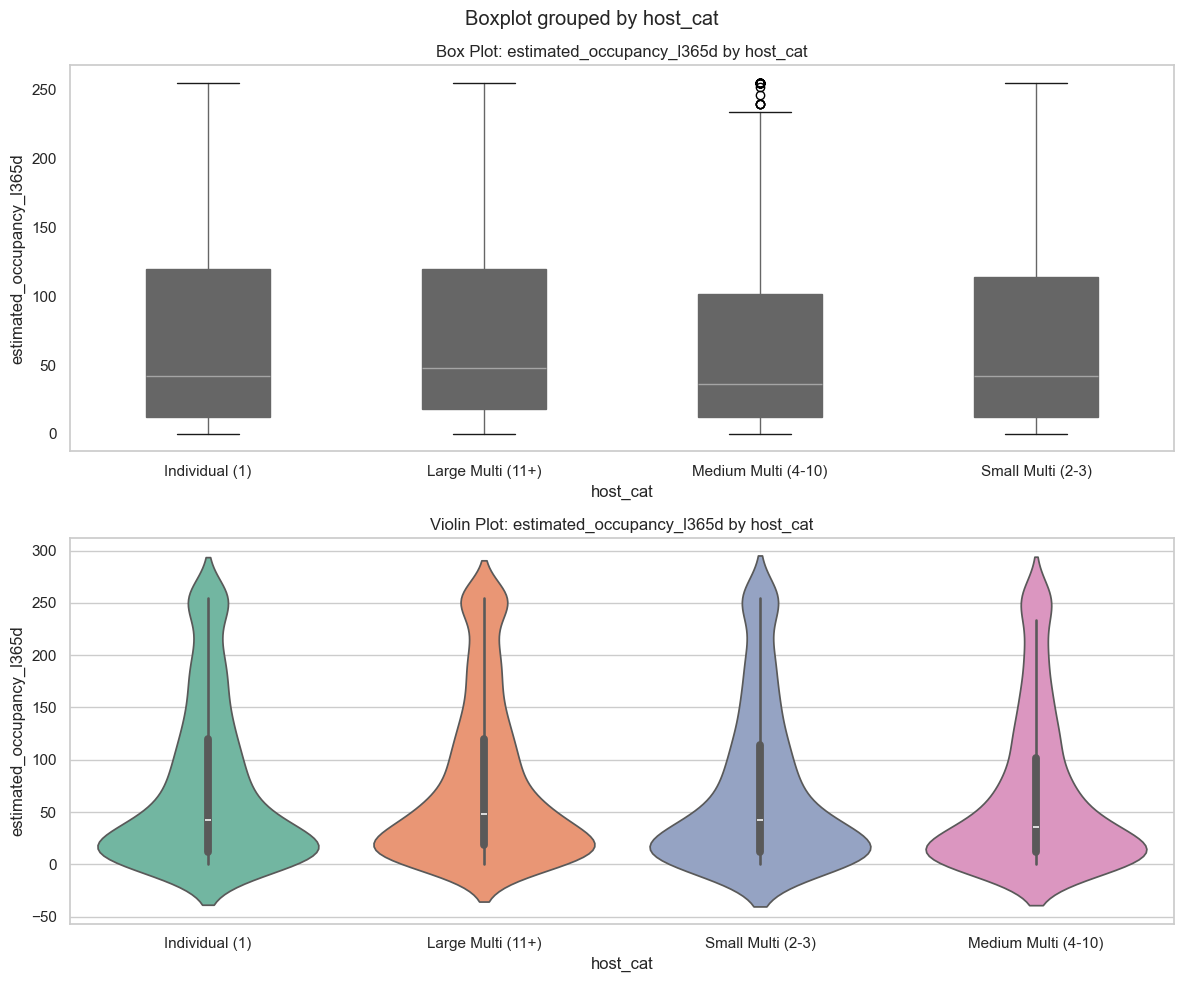

ONE-WAY ANOVA: estimated_occupancy_l365d by host_cat

Descriptive Statistics by Group:

  host_cat = Individual (1):
    N:      1003
    Mean:   75.1446
    Median: 42.0000
    Std:    76.9918
    Min:    0.0000
    Max:    255.0000

  host_cat = Large Multi (11+):
    N:      1549
    Mean:   78.0710
    Median: 48.0000
    Std:    77.3743
    Min:    0.0000
    Max:    255.0000

  host_cat = Small Multi (2-3):
    N:      765
    Mean:   71.2497
    Median: 42.0000
    Std:    75.9631
    Min:    0.0000
    Max:    255.0000

  host_cat = Medium Multi (4-10):
    N:      780
    Mean:   66.2269
    Median: 36.0000
    Std:    73.9904
    Min:    0.0000
    Max:    255.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      4.5578
  P-value:             0.003419
  Eta-squared (η²):    0.003
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.003419). host_cat has a significant effect o

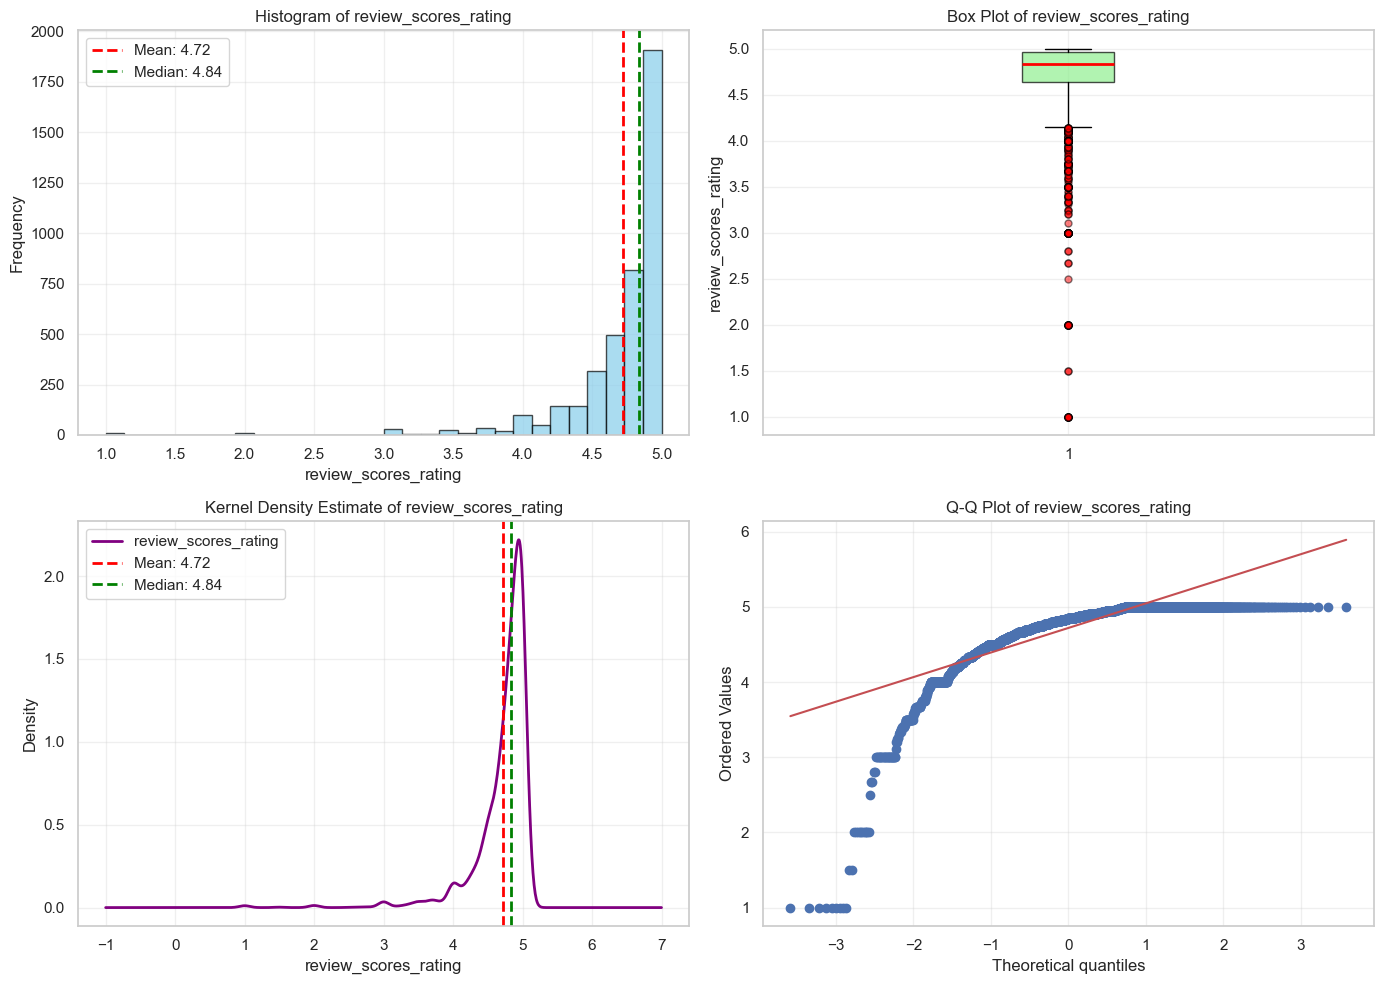

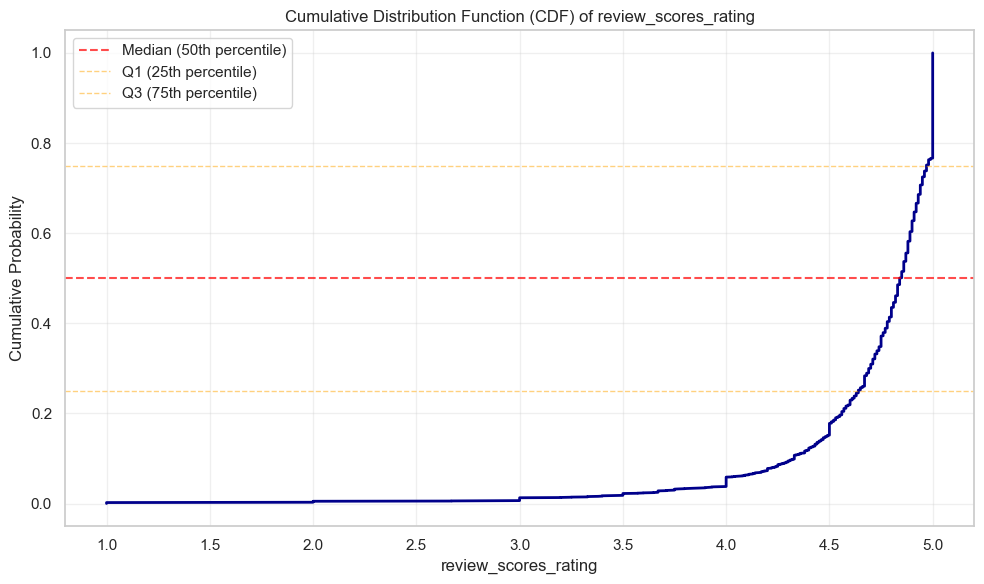

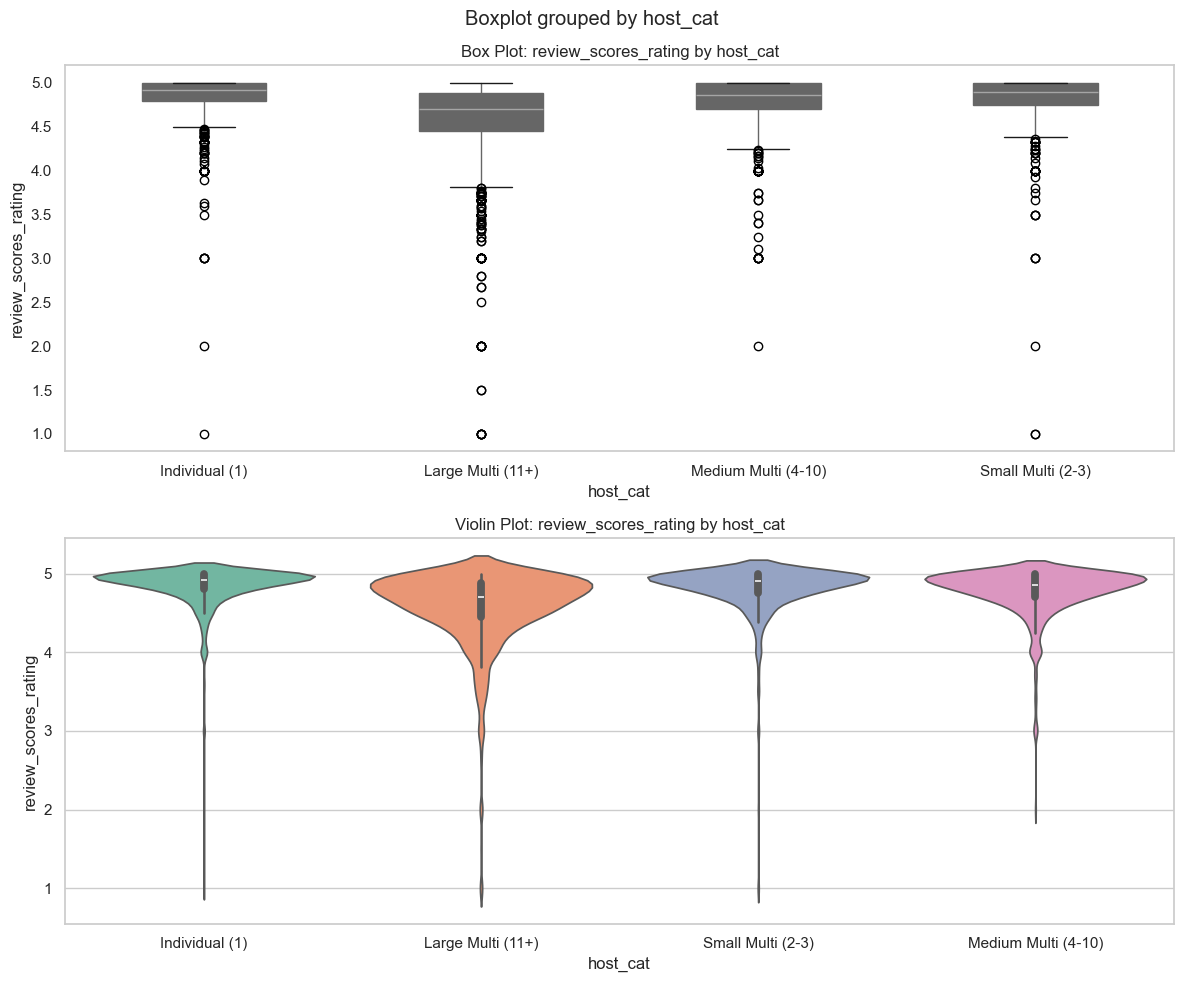

ONE-WAY ANOVA: review_scores_rating by host_cat

Descriptive Statistics by Group:

  host_cat = Individual (1):
    N:      1003
    Mean:   4.8399
    Median: 4.9200
    Std:    0.2808
    Min:    1.0000
    Max:    5.0000

  host_cat = Large Multi (11+):
    N:      1549
    Mean:   4.5707
    Median: 4.7000
    Std:    0.5014
    Min:    1.0000
    Max:    5.0000

  host_cat = Small Multi (2-3):
    N:      765
    Mean:   4.8081
    Median: 4.9000
    Std:    0.3340
    Min:    1.0000
    Max:    5.0000

  host_cat = Medium Multi (4-10):
    N:      780
    Mean:   4.7721
    Median: 4.8600
    Std:    0.3187
    Min:    2.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      122.9412
  P-value:             0.000000
  Eta-squared (η²):    0.083
  Effect size:         Medium effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_cat has a significant effect on review_scores_rating. Med

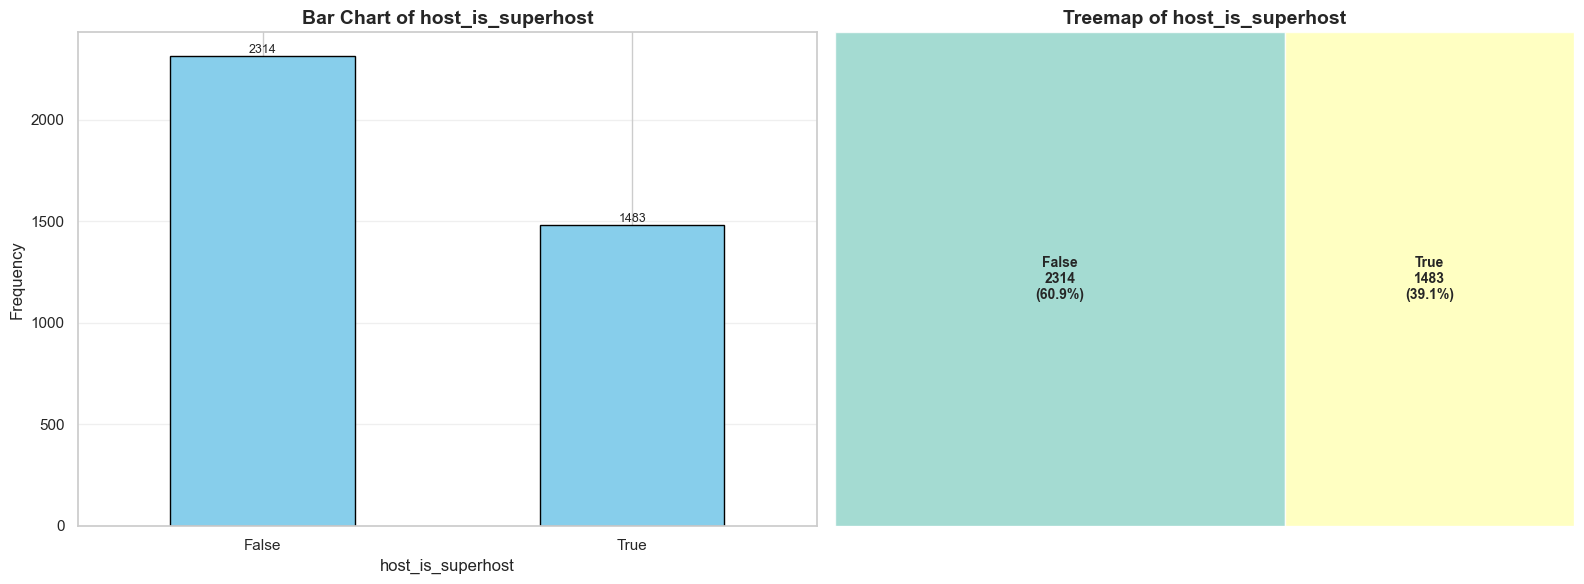

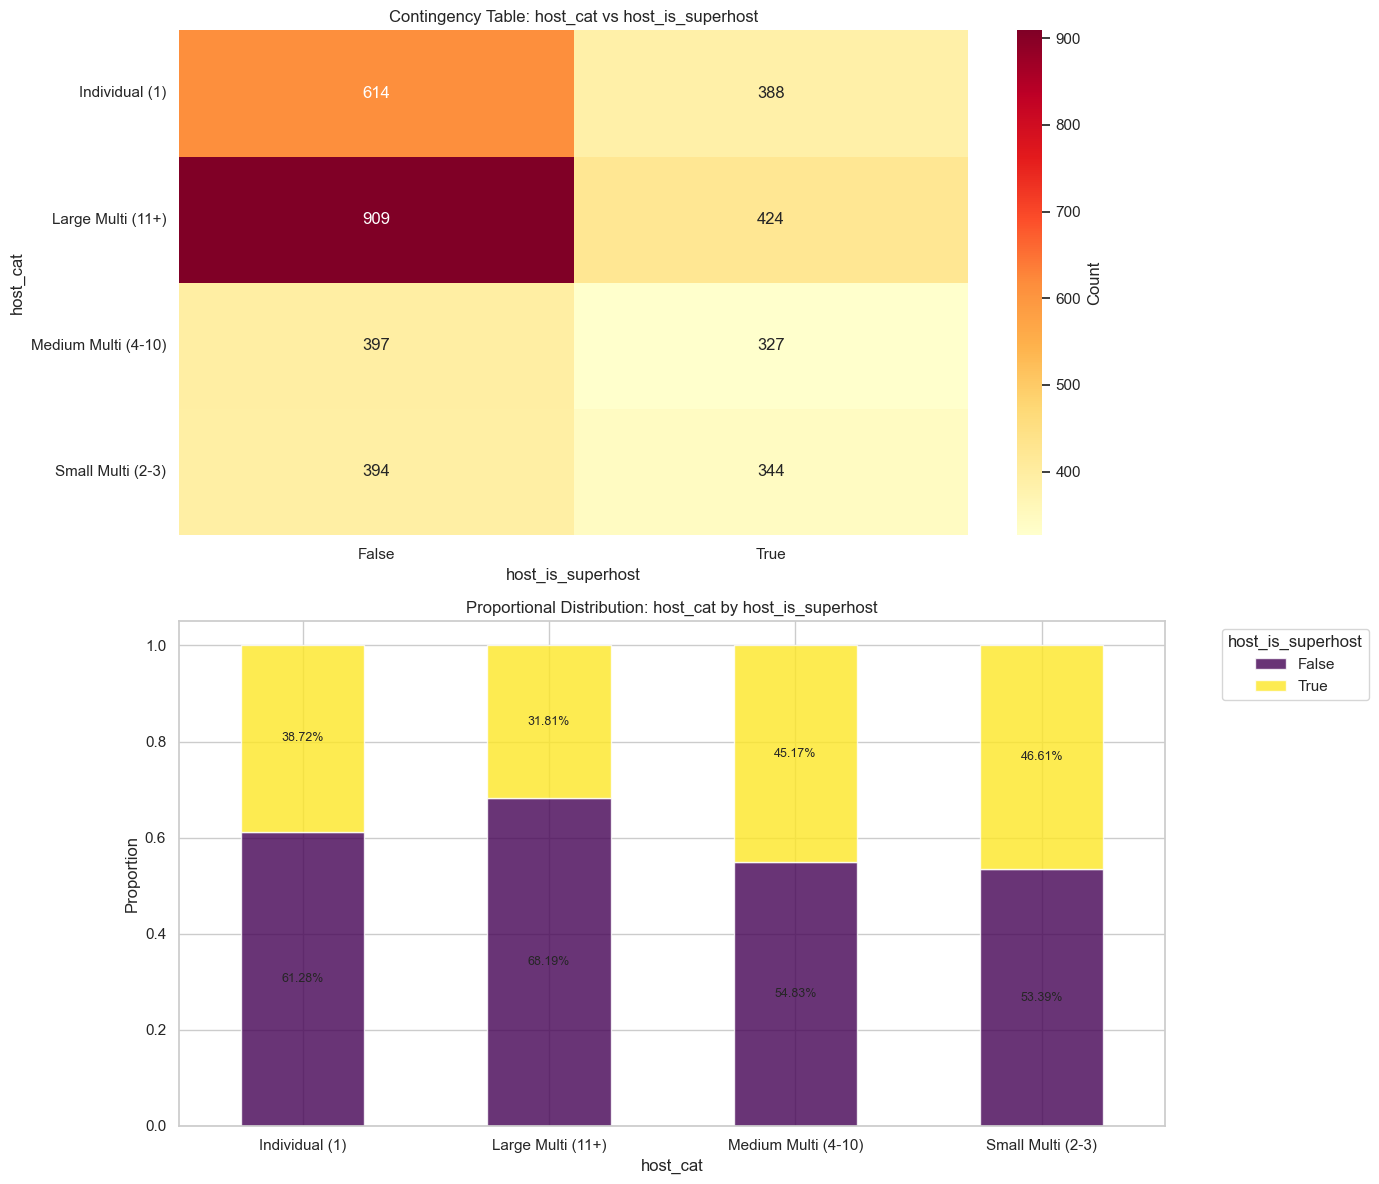

CHI-SQUARE TEST OF INDEPENDENCE: host_cat vs host_is_superhost

Contingency Table:
host_is_superhost    False  True 
host_cat                         
Individual (1)         614    388
Large Multi (11+)      909    424
Medium Multi (4-10)    397    327
Small Multi (2-3)      394    344

Test Statistics:
  Chi-square statistic: 58.5255
  Degrees of freedom:   3
  P-value:              0.000000
  Cramér's V:           0.124
  Effect size:          Weak association
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT association detected (p=0.000000). host_cat and host_is_superhost are related. Weak association (Cramér's V = 0.124).

 

DESCRIPTIVE STATISTICS: host_acceptance_rate

Central Tendency:
  Mean:           0.95
  Median:         1.00
  Mode:           1.0

Dispersion:
  Std Dev:        0.16
  Variance:       0.02
  Range:          1.00
  IQR:            0.01

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       0.99
  Q2 (50%):       1.00
  Q3 (75%):       1.00
  Max (100

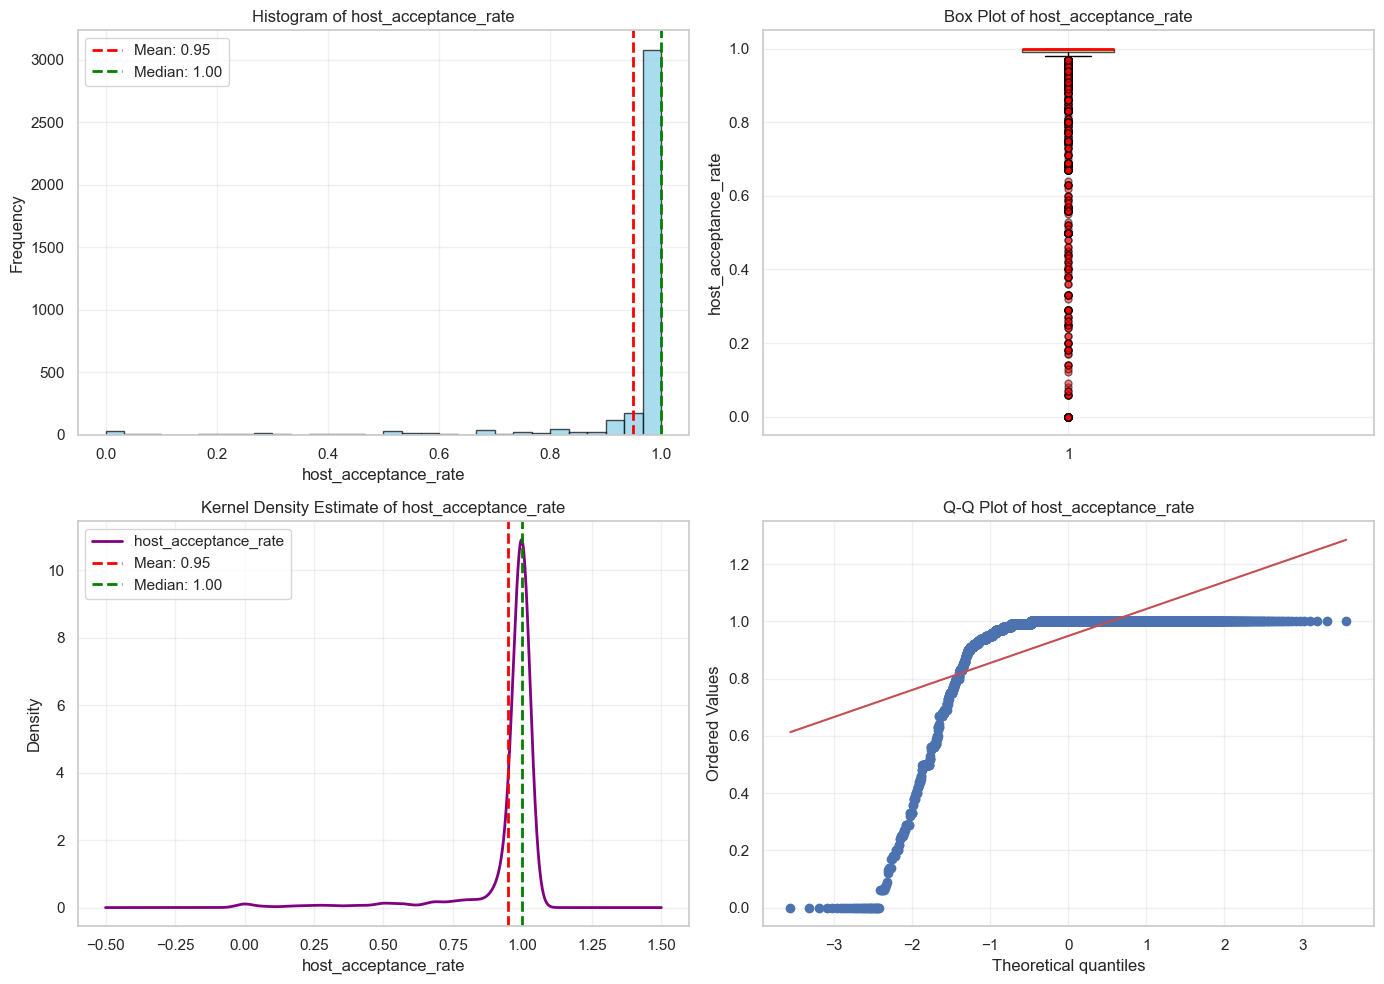

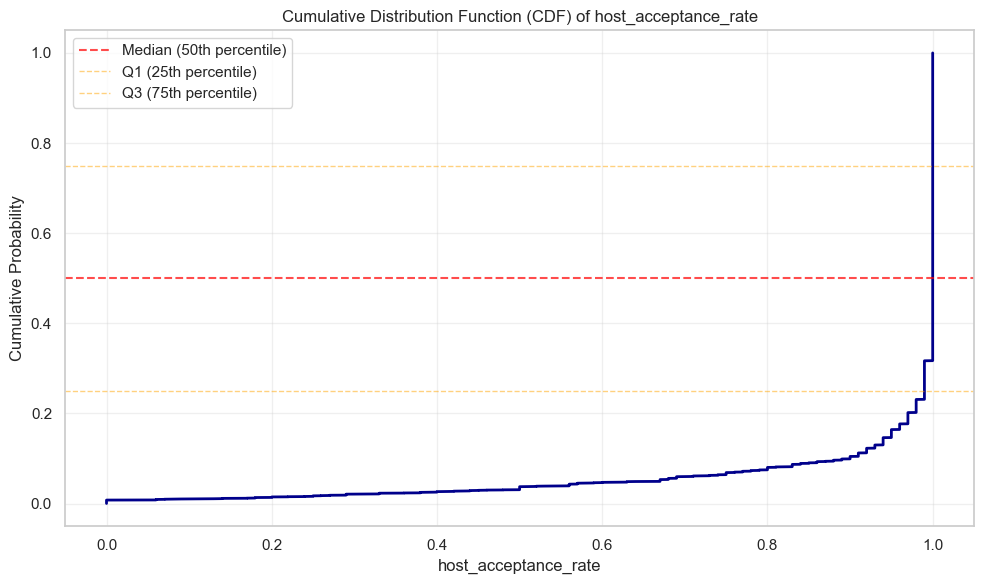

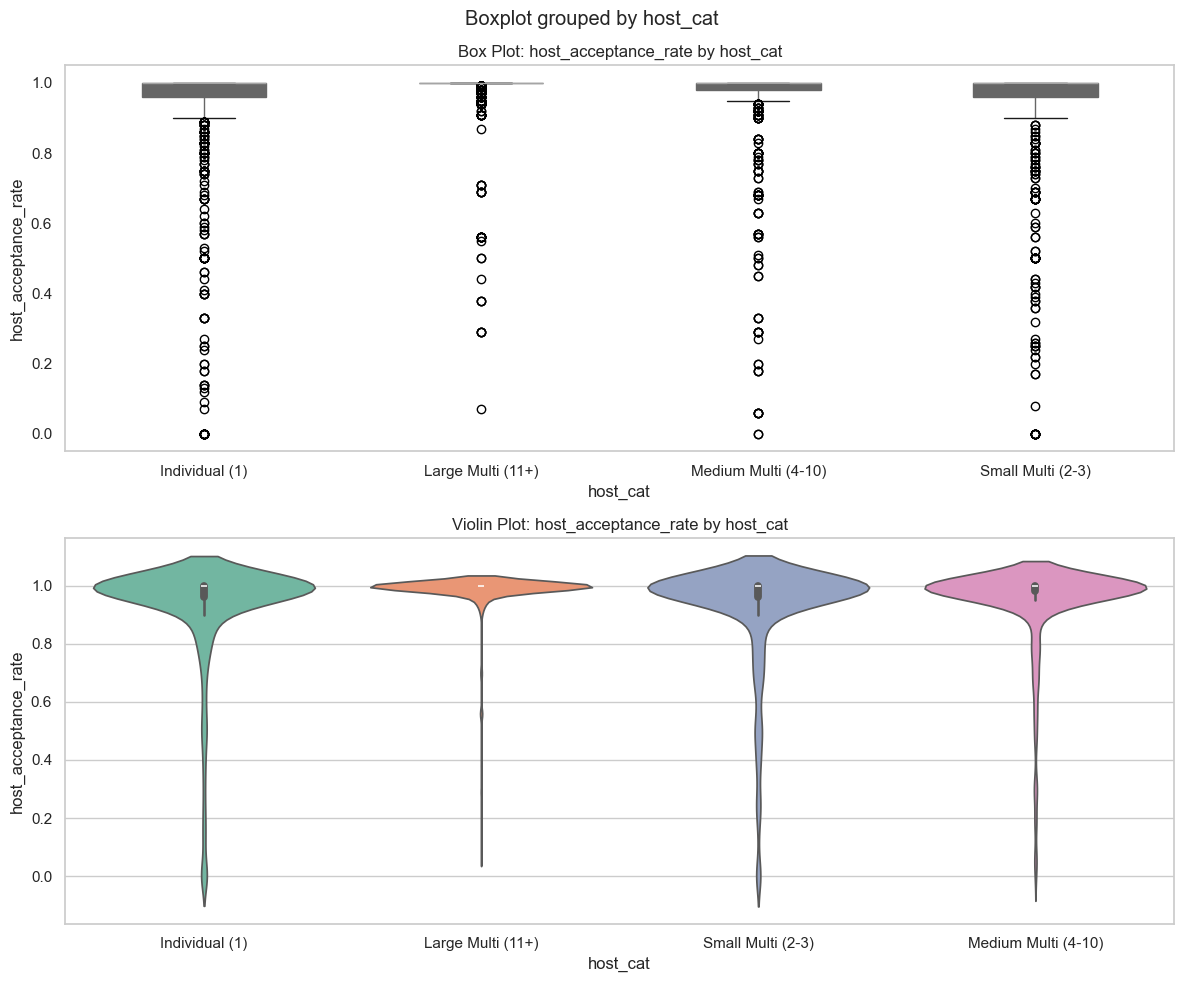

ONE-WAY ANOVA: host_acceptance_rate by host_cat

Descriptive Statistics by Group:

  host_cat = Individual (1):
    N:      884
    Mean:   0.9230
    Median: 1.0000
    Std:    0.1980
    Min:    0.0000
    Max:    1.0000

  host_cat = Large Multi (11+):
    N:      1414
    Mean:   0.9839
    Median: 1.0000
    Std:    0.0751
    Min:    0.0700
    Max:    1.0000

  host_cat = Small Multi (2-3):
    N:      708
    Mean:   0.9200
    Median: 1.0000
    Std:    0.1932
    Min:    0.0000
    Max:    1.0000

  host_cat = Medium Multi (4-10):
    N:      734
    Mean:   0.9429
    Median: 1.0000
    Std:    0.1584
    Min:    0.0000
    Max:    1.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      41.9766
  P-value:             0.000000
  Eta-squared (η²):    0.033
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_cat has a significant effect on host_acceptance_rate. Small 

In [ ]:
for var in variables:
    
    if pd.api.types.is_numeric_dtype(df[var]):
        
        analyze_numeric_variable(df[var])
        analyze_categorical_numerical(df["host_cat"], df[var])

    else:
        
        analyze_categorical_variable(df[var])
        analyze_categorical_categorical(df["host_cat"], df[var])

    print("\n", "\n")

<hr>

#### Main Findings

### 0 - listing age

"Large Multi (11+) hosts show statistically younger listings (median 1.6 years) compared to other categories (median 1.9-2.4 years), suggesting recent market entry by commercial operators (Kruskal-Wallis H=XX.X, p<0.001). While the effect size is small (η²=0.024), this pattern indicates growing professionalization of Thessaloniki's STR market in recent years."

The finding supports a narrative that corporate/commercial operators have expanded more recently, which is policy-relevant for:

Monitoring market concentration trends
Understanding if regulations prompted or deterred professional entry
Forecasting future market structure

In [ ]:
from scipy import stats


# Kruskal-Wallis (non-parametric ANOVA alternative)
groups = [df[df['host_cat'] == cat]['listing_age_years'].dropna() 
          for cat in df['host_cat'].dropna().unique()]
stat, p = stats.kruskal(*groups)
print(f"Kruskal-Wallis H={stat:.3f}, p={p:.6f}")

Kruskal-Wallis H=82.201, p=0.000000


### 1 - Estimated revenue

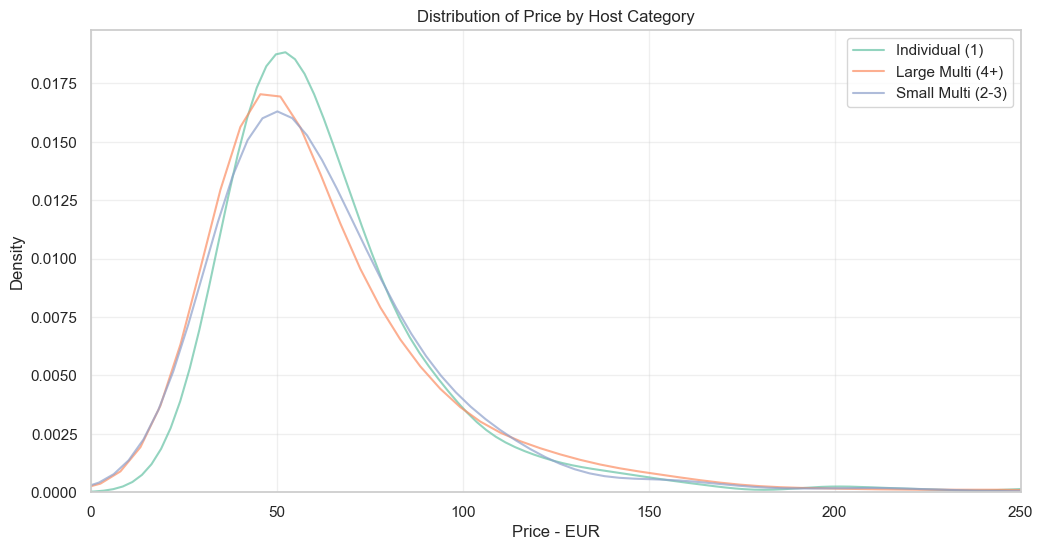

In [ ]:
plt.figure(figsize=(12, 6))
for category in df["Host_Category"].unique():
    data = df[df['Host_Category'] == category]['price'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Price - EUR')
plt.ylabel('Density')
plt.title('Distribution of Price by Host Category')
plt.xlim(0, 250)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from scipy import stats

# Kruskal-Wallis test (non-parametric alternative to ANOVA)
groups = [
    df[df['Host_Category'] == 'Individual (1)']['estimated_revenue_l365d'].dropna(),
    df[df['Host_Category'] == 'Small Multi (2-3)']['estimated_revenue_l365d'].dropna(),
    df[df['Host_Category'] == 'Large Multi (4+)']['estimated_revenue_l365d'].dropna()
]

stat, p_value = stats.kruskal(*groups)
print(f"Kruskal-Wallis H={stat:.3f}, p={p_value:.4f}")

Kruskal-Wallis H=3.740, p=0.1541


In [ ]:
# Compare ANOVA vs Kruskal-Wallis
print("Parametric (ANOVA):", f_stat, p_value_anova)
print("Non-parametric (Kruskal-Wallis):", h_stat, p_value_kw)

"Revenue does not differ significantly across host categories (Kruskal-Wallis H=X.XX, p=0.XX). Both parametric and non-parametric tests confirm negligible effect size (η² ≈ 0), indicating host type does not predict revenue performance."

Document the price distribution in your technical notebook with a note that "pricing strategies are consistent across host types, confirming revenue differences reflect operational performance rather than pricing positioning.

In [ ]:
df["estimated_revenue_l365d"].describe()

count      4173.000000
mean       3998.912054
std        5747.099720
min           0.000000
25%         468.000000
50%        1980.000000
75%        5712.000000
max      109896.000000
Name: estimated_revenue_l365d, dtype: float64

est revenue
* Average estimated revenue seems to be a little larger for individual hosts followed closely by multi hosts.
* Individuals and multi hosts show similar distribution until 3000 euros, then 4+ shows bigger density in the 3000 to 7000 range and lastly the indiual listing hosts show bigger density in the 7000 to 15000 range
* 2-3 category isalways below each of those two although close 

Est occupancy
* nothing importand to note here, all categories show the same characteristics

### 2 - estimated occupancy

"Occupancy rates show no meaningful variation across host categories (η² = 0.003, negligible effect), despite statistical significance (p = 0.003). This suggests that guest booking behavior is not biased toward professional operators—individual hosts achieve comparable occupancy to large multi-listing hosts. This finding supports a competitive market structure where scale provides no inherent advantage in attracting bookings."

### 3 - Reviews rating

In [ ]:
# Kruskal-Wallis test with epsilon-squared effect size for review ratings
from scipy import stats

# Prepare groups
categories = ['Individual (1)', 'Small Multi (2-3)', 'Medium Multi (4-10)', 'Large Multi (11+)']
groups = [df[df['host_cat'] == cat]['review_scores_rating'].dropna() for cat in categories]

# Kruskal-Wallis test (non-parametric)
h_stat, p_value = stats.kruskal(*groups)

# Calculate epsilon-squared (ε²) - appropriate effect size for Kruskal-Wallis
# Formula: ε² = H / (n - 1)
n_total = sum(len(g) for g in groups)
epsilon_squared = h_stat / (n_total - 1)

# Interpretation thresholds for epsilon-squared (similar to eta-squared)
if epsilon_squared < 0.01:
    effect_interp = "negligible"
elif epsilon_squared < 0.06:
    effect_interp = "small"
elif epsilon_squared < 0.14:
    effect_interp = "medium"
else:
    effect_interp = "large"

print("="*70)
print("REVIEW SCORES BY HOST CATEGORY (Non-parametric Test)")
print("="*70)
print(f"\nKruskal-Wallis H = {h_stat:.3f}, p = {p_value:.6f}")
print(f"Epsilon-squared (ε²) = {epsilon_squared:.4f} ({effect_interp} effect)")
print(f"\nDescriptive Statistics:")
for cat, grp in zip(categories, groups):
    print(f"  {cat}: median={grp.median():.2f}, mean={grp.mean():.3f}, std={grp.std():.3f}, n={len(grp)}")

REVIEW SCORES BY HOST CATEGORY (Non-parametric Test)

Kruskal-Wallis H = 503.137, p = 0.000000
Epsilon-squared (ε²) = 0.1228 (medium effect)

Descriptive Statistics:
  Individual (1): median=4.92, mean=4.840, std=0.281, n=1003
  Small Multi (2-3): median=4.90, mean=4.808, std=0.334, n=765
  Medium Multi (4-10): median=4.86, mean=4.772, std=0.319, n=780
  Large Multi (11+): median=4.70, mean=4.571, std=0.501, n=1549


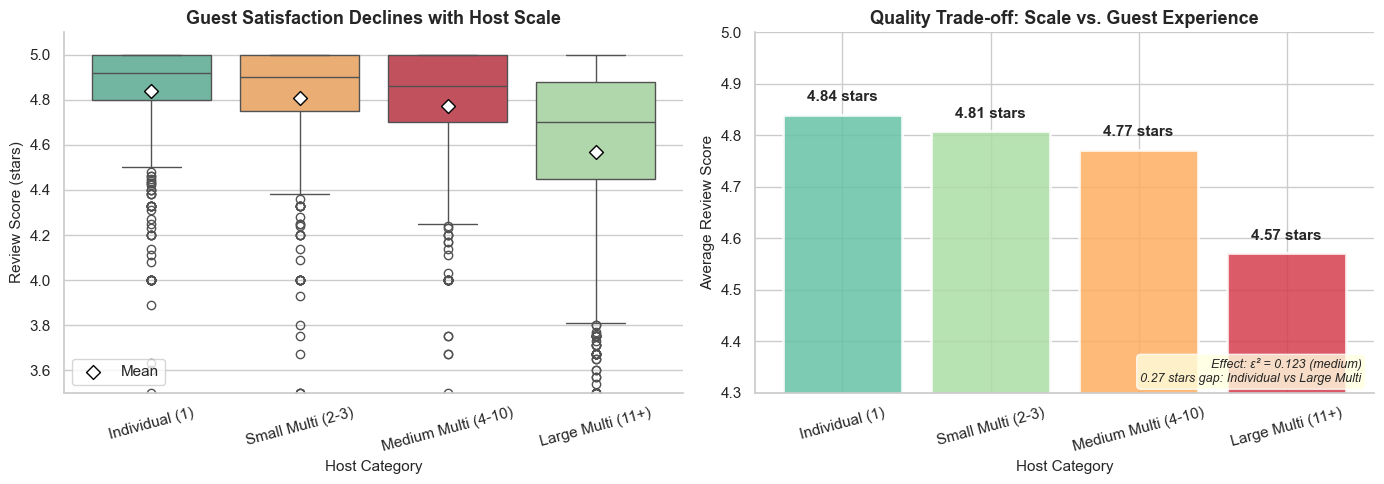

In [ ]:


# Visualization: Review Scores by Host Category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Box plot showing distribution
order = ['Individual (1)', 'Small Multi (2-3)', 'Medium Multi (4-10)', 'Large Multi (11+)']
colors = ['#66c2a5', '#abdda4', '#fdae61', '#d53e4f']  # Green to red gradient

# Fix FutureWarning by adding hue parameter
box = sns.boxplot(data=df, x='host_cat', y='review_scores_rating', order=order, 
                  hue='host_cat', palette=colors, legend=False, ax=axes[0])
axes[0].set_xlabel('Host Category', fontsize=11)
axes[0].set_ylabel('Review Score (stars)', fontsize=11)
axes[0].set_title('Guest Satisfaction Declines with Host Scale', fontsize=13, fontweight='bold')
axes[0].set_ylim(3.5, 5.1)

# Add mean markers
means = [df[df['host_cat'] == cat]['review_scores_rating'].mean() for cat in order]
axes[0].scatter(range(4), means, color='white', s=50, zorder=5, edgecolor='black', marker='D', label='Mean')
axes[0].legend(loc='lower left')

# Right: Bar chart without error bars (removed yerr parameter)
medians = [df[df['host_cat'] == cat]['review_scores_rating'].median() for cat in order]
stds = [df[df['host_cat'] == cat]['review_scores_rating'].std() for cat in order]

bars = axes[1].bar(order, means, color=colors, 
                   edgecolor='white', linewidth=2, alpha=0.85)

# Add value labels - replace star symbol with text to avoid font warning
for bar, mean in zip(bars, means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{mean:.2f} stars', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1].set_ylim(4.3, 5.0)
axes[1].set_xlabel('Host Category', fontsize=11)
axes[1].set_ylabel('Average Review Score', fontsize=11)
axes[1].set_title('Quality Trade-off: Scale vs. Guest Experience', fontsize=13, fontweight='bold')

# Add annotation - replace star symbol with text
axes[1].annotate(f'Effect: ε² = {epsilon_squared:.3f} (medium)\n0.27 stars gap: Individual vs Large Multi',
                 xy=(0.98, 0.02), xycoords='axes fraction', ha='right', va='bottom',
                 fontsize=9, style='italic',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

"While professional operators show marginally better operational metrics (acceptance rates), guest satisfaction tells the opposite story: Individual hosts achieve the highest ratings (4.84★) with the most consistency, while large multi-listing hosts show both lower scores (4.57★) and greater variability. This 0.27-star gap represents a meaningful quality trade-off that policymakers should consider when evaluating market concentration."

### host acceptance rate

host acceptance rate is noticeably smaller 

### Superhost status

"The Sweet Spot of Host Professionalization"

Small and medium multi-listing hosts (2-10 listings) achieve the highest superhost rates (45-47%), significantly outperforming both individual hosts (39%) and large commercial operators (32%). This suggests a "growth mindset" phase where operators are actively investing in guest experience to build their business reputation.

Individual hosts, while providing authentic experiences, may lack the motivation to pursue platform-specific metrics. Large operators, managing 11+ listings, appear to prioritize operational efficiency over personalized service, resulting in fewer superhost certifications.

This pattern has implications for market quality: the mid-scale segment (2-10 listings) appears to optimize for both growth AND guest satisfaction, making them potentially the most desirable host category from a tourism quality perspective.

But does superhost status translate to tangible performance advantages? The following analysis explores whether this quality investment pays off...

In [ ]:
# Chi-square test for Host Category vs Superhost Status
from scipy.stats import chi2_contingency
import numpy as np

# Create contingency table
contingency = pd.crosstab(df['host_cat'], df['host_is_superhost'])
print("Contingency Table:")
print(contingency)
print()

# Calculate percentages (superhost rate per category)
contingency_pct = pd.crosstab(df['host_cat'], df['host_is_superhost'], normalize='index') * 100
print("Superhost Rate by Category (%):")
print(contingency_pct.round(1))
print()

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency)

# Cramér's V effect size
n = contingency.sum().sum()
min_dim = min(contingency.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("="*60)
print("CHI-SQUARE TEST: Host Category vs Superhost Status")
print("="*60)
print(f"Chi-square statistic: χ² = {chi2:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.6f}")
print(f"Cramér's V: {cramers_v:.3f}")

# Interpret effect size
if cramers_v < 0.1:
    effect = "negligible"
elif cramers_v < 0.2:
    effect = "weak"
elif cramers_v < 0.4:
    effect = "moderate"
else:
    effect = "strong"
print(f"Effect size interpretation: {effect}")

In [ ]:
# Pairwise proportion tests to identify which categories differ
from scipy.stats import norm
from itertools import combinations

def z_test_proportions(n1, p1, n2, p2):
    """Two-proportion z-test"""
    p_pool = (n1*p1 + n2*p2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z = (p1 - p2) / se
    p_value = 2 * (1 - norm.cdf(abs(z)))  # two-tailed
    return z, p_value

# Calculate superhost rates and sample sizes
categories = ['Individual (1)', 'Small Multi (2-3)', 'Medium Multi (4-10)', 'Large Multi (11+)']
rates = {}
sizes = {}

for cat in categories:
    cat_data = df[df['host_cat'] == cat]['host_is_superhost']
    rates[cat] = cat_data.mean()
    sizes[cat] = len(cat_data)

print("="*60)
print("PAIRWISE COMPARISONS: Superhost Rate Differences")
print("="*60)
print(f"\nSuperhost Rates:")
for cat in categories:
    print(f"  {cat}: {rates[cat]*100:.1f}% (n={sizes[cat]})")

print(f"\nPairwise Z-tests (Bonferroni-corrected α = {0.05/6:.4f}):")
print("-"*60)

comparisons = list(combinations(categories, 2))
results = []

for cat1, cat2 in comparisons:
    z, p = z_test_proportions(sizes[cat1], rates[cat1], sizes[cat2], rates[cat2])
    diff = (rates[cat1] - rates[cat2]) * 100
    significant = p < (0.05 / 6)  # Bonferroni correction for 6 comparisons
    results.append((cat1, cat2, diff, z, p, significant))
    sig_marker = "***" if significant else ""
    print(f"{cat1} vs {cat2}:")
    print(f"    Difference: {diff:+.1f}pp, z={z:.2f}, p={p:.4f} {sig_marker}")

In [ ]:
# Visualization: Superhost Rate by Host Category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate rates
categories = ['Individual (1)', 'Small Multi (2-3)', 'Medium Multi (4-10)', 'Large Multi (11+)']
superhost_rates = [df[df['host_cat'] == cat]['host_is_superhost'].mean() * 100 for cat in categories]
sample_sizes = [len(df[df['host_cat'] == cat]) for cat in categories]

# Left: Bar chart of superhost rates
colors = ['#66c2a5', '#1a9850', '#1a9850', '#d53e4f']  # Highlight middle categories
bars = axes[0].bar(categories, superhost_rates, color=colors, edgecolor='white', linewidth=2, alpha=0.85)

# Add value labels
for bar, rate, n in zip(bars, superhost_rates, sample_sizes):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{rate:.1f}%\n(n={n})', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[0].set_ylim(0, 60)
axes[0].set_xlabel('Host Category', fontsize=11)
axes[0].set_ylabel('Superhost Rate (%)', fontsize=11)
axes[0].set_title('Superhost Achievement by Host Scale\n(Mid-scale operators lead in quality certification)', 
                  fontsize=12, fontweight='bold')
axes[0].axhline(y=df['host_is_superhost'].mean()*100, color='gray', linestyle='--', alpha=0.7, label='Overall avg')
axes[0].legend()

# Right: Stacked bar showing composition
contingency_pct = pd.crosstab(df['host_cat'], df['host_is_superhost'], normalize='index') * 100
contingency_pct = contingency_pct.reindex(categories)

contingency_pct.plot(kind='bar', stacked=True, ax=axes[1], 
                      color=['#fee08b', '#1a9850'], edgecolor='white', linewidth=1)
axes[1].set_xlabel('Host Category', fontsize=11)
axes[1].set_ylabel('Percentage (%)', fontsize=11)
axes[1].set_title('Superhost Composition by Category', fontsize=12, fontweight='bold')
axes[1].legend(['Non-Superhost', 'Superhost'], loc='upper right')
axes[1].set_xticklabels(categories, rotation=15)

# Add annotation
axes[0].annotate(f"Cramér's V = {cramers_v:.3f} (weak association)\nChi² = {chi2:.1f}, p < 0.001",
                 xy=(0.98, 0.98), xycoords='axes fraction', ha='right', va='top',
                 fontsize=9, style='italic',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

tatistical finding: Significant association between host category and superhost status (χ²=58.5, p<0.001), though effect size is weak (Cramér's V=0.124)

Pattern: Inverted-U relationship - mid-scale hosts (2-10 listings) achieve highest superhost rates

Narrative: "Growth mindset" operators invest in quality to build reputation

Policy angle: Mid-scale segment may represent optimal balance of professionalization and guest experience quality

Transition: "But does this quality certification translate to revenue? Let's examine the superhost premium..."

### 5 - Acceptance rate

Professional hosts (4+ listings) demonstrate marginally higher operational standards, with ~5 percentage points higher acceptance rates, suggesting more systematic management practices

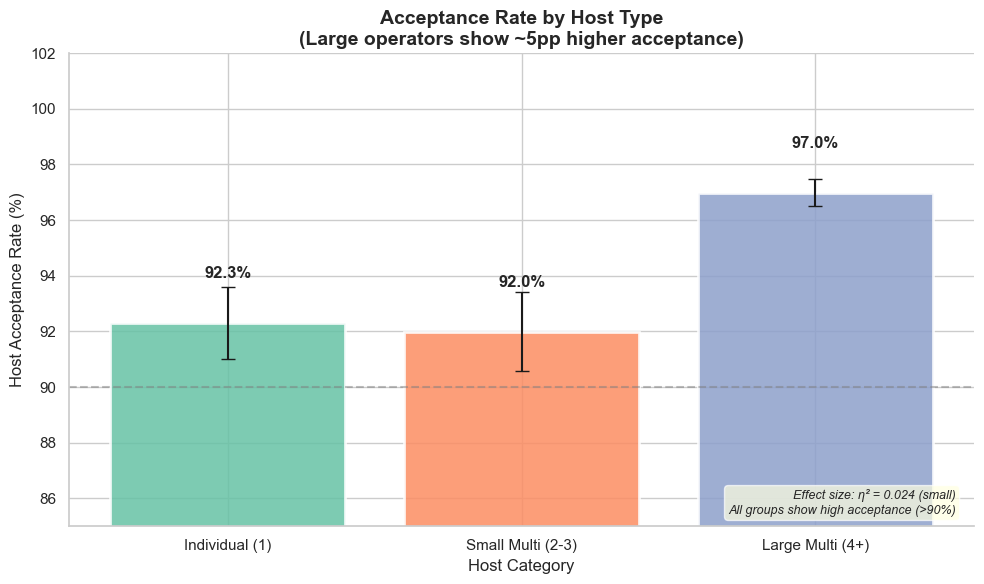

In [ ]:
# Calculate means and 95% CI for each group
categories = ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']
means = []
cis = []

for cat in categories:
    data = df[df['Host_Category'] == cat]['host_acceptance_rate'].dropna()
    mean = data.mean()
    ci = 1.96 * data.std() / np.sqrt(len(data))
    means.append(mean * 100)  # Convert to percentage
    cis.append(ci * 100)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart
bars = ax.bar(categories, means, yerr=cis, capsize=5, 
              color=['#66c2a5', '#fc8d62', '#8da0cb'], 
              edgecolor='white', linewidth=2, alpha=0.85)

# Add value labels
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{mean:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
ax.set_ylim(85, 102)
ax.set_ylabel('Host Acceptance Rate (%)', fontsize=12)
ax.set_xlabel('Host Category', fontsize=12)
ax.set_title('Acceptance Rate by Host Type\n(Large operators show ~5pp higher acceptance)', 
             fontsize=14, fontweight='bold')

# Add baseline reference
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5)

# Add annotation for effect size
ax.annotate('Effect size: η² = 0.024 (small)\nAll groups show high acceptance (>90%)',
            xy=(0.98, 0.02), xycoords='axes fraction',
            ha='right', va='bottom', fontsize=9, style='italic',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

"While all host types demonstrate strong acceptance rates (>90%), professional operators (4+ listings) show statistically higher rates (97% vs 92%, p < 0.001). However, the effect size is small (η² = 0.024), explaining only 2.4% of variance. This suggests professionalization provides marginal operational improvements, though the market overall exhibits healthy responsiveness regardless of host type."

Large multi-property operators accept almost everything (98.4%) because:

Volume over selectivity - They're running a numbers game, not curating guest experiences
Lower standards - They don't turn away "risky" bookings that individual hosts might decline
Efficiency-driven - Less time spent evaluating each request, just accept and move on
No personal stake - It's not their home, so less concern about who stays
Meanwhile, individual hosts are more selective (92.3%) because:

They care about guest fit
They may decline last-minute requests or short stays
They protect their property/neighborhood relationships
The Irony
High acceptance rate + Low quality scores = "Accept everyone, deliver less"

This is the opposite of a superhost approach (which emphasizes selective quality).

My Recommendation
Yes, make a brief mention - perhaps a single sentence in your narrative like:

"Notably, Large Multi operators exhibit the highest acceptance rates (98.4% vs 92.3% for Individual hosts), suggesting a volume-over-selectivity approach that prioritizes booking quantity rather than guest-host fit—consistent with their lower quality scores."

The small effect size (η²=0.033) means you shouldn't belabor it, but it's a nice supporting detail that completes the picture of the "corporate approach."

<hr>

**comment**
* small multi and invidual listing host show similar availability patterns
* large multi seem to have more days of availability on average which indicates larger particiapation in the market

correlation analysis

In [ ]:
# Compare superhosts vs non-superhosts within each category
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    cat_data = df[df['Host_Category'] == category]
    
    superhosts = cat_data[cat_data['host_is_superhost'] == True]
    non_superhosts = cat_data[cat_data['host_is_superhost'] == False]
    
    print(f"\n{category}:")
    print(f"Superhost avg revenue: {superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Non-superhost avg revenue: {non_superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Superhost avg rating: {superhosts['review_scores_rating'].mean():.2f}")
    print(f"Non-superhost avg rating: {non_superhosts['review_scores_rating'].mean():.2f}")


Individual (1):
Superhost avg revenue: 7631.87
Non-superhost avg revenue: 1998.03
Superhost avg rating: 4.91
Non-superhost avg rating: 4.79

Small Multi (2-3):
Superhost avg revenue: 6534.67
Non-superhost avg revenue: 1763.80
Superhost avg rating: 4.89
Non-superhost avg rating: 4.73

Large Multi (4+):
Superhost avg revenue: 5150.49
Non-superhost avg revenue: 2986.11
Superhost avg rating: 4.85
Non-superhost avg rating: 4.50


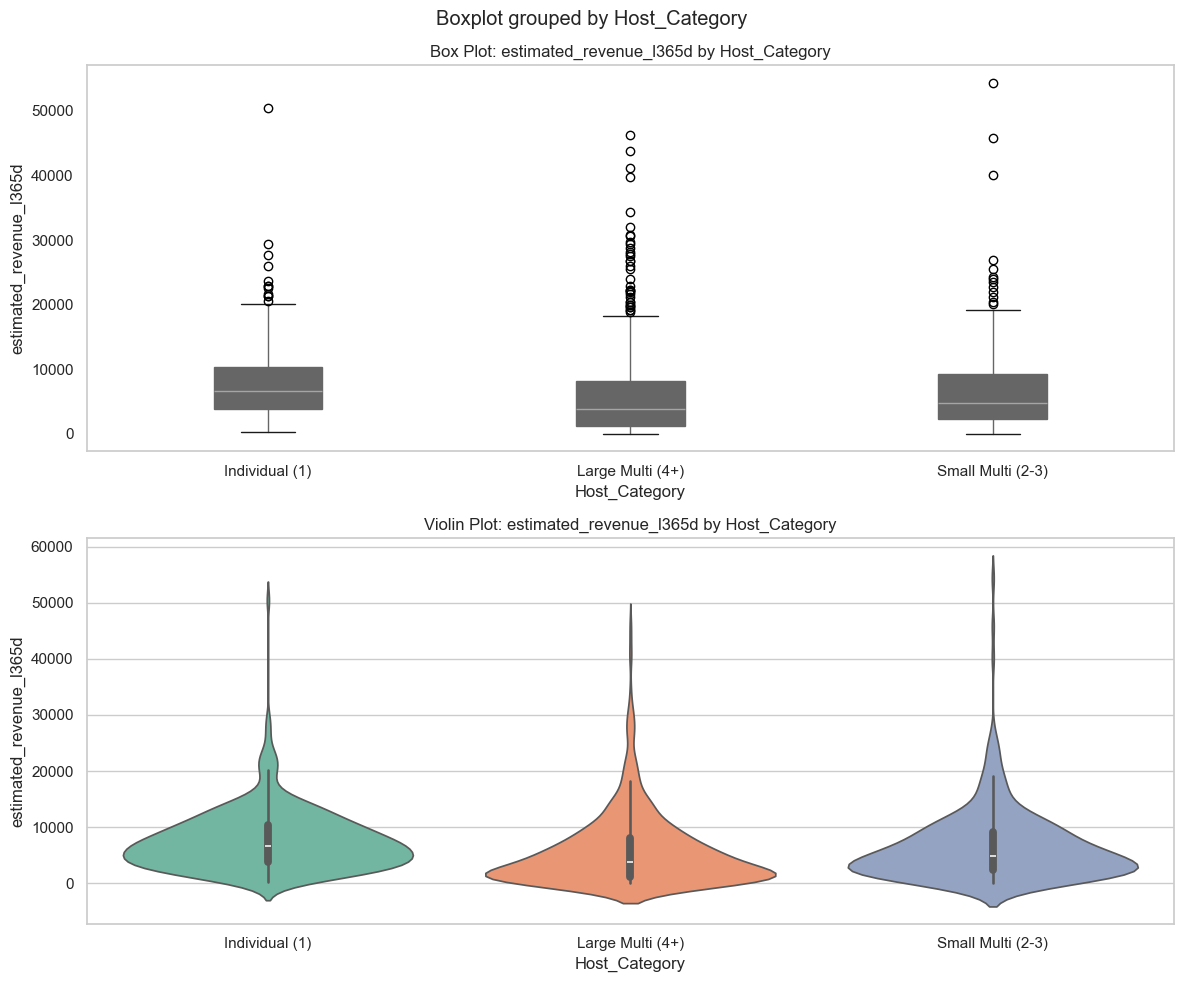

ONE-WAY ANOVA: estimated_revenue_l365d by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      370
    Mean:   7652.5000
    Median: 6669.0000
    Std:    5431.8139
    Min:    336.0000
    Max:    50430.0000

  Host_Category = Large Multi (4+):
    N:      715
    Mean:   5791.7259
    Median: 3840.0000
    Std:    6538.6792
    Min:    0.0000
    Max:    46320.0000

  Host_Category = Small Multi (2-3):
    N:      328
    Mean:   6613.5366
    Median: 4830.0000
    Std:    6527.8958
    Min:    0.0000
    Max:    54315.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      10.8660
  P-value:             0.000021
  Eta-squared (η²):    0.015
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000021). Host_Category has a significant effect on estimated_revenue_l365d. Small effect (Eta-squared (η²) = 0.015).

Assumption Checks:
  Normality (Shapiro-

In [ ]:
sh_df = df.loc[df["host_is_superhost"] == True]
analyze_categorical_numerical(sh_df["Host_Category"], sh_df["estimated_revenue_l365d"])

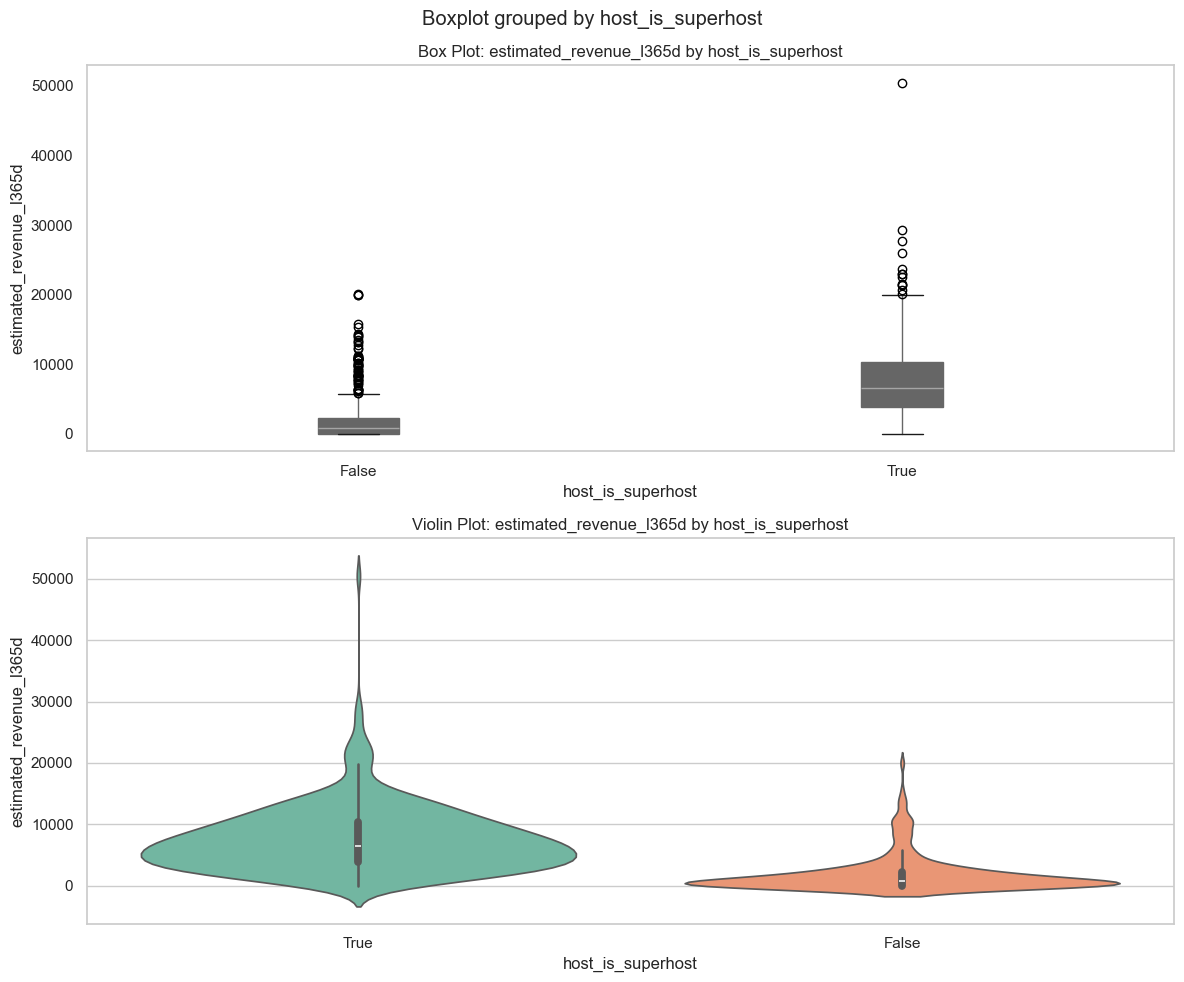

WELCH'S T-TEST: estimated_revenue_l365d by host_is_superhost

Descriptive Statistics by Group:

  host_is_superhost = True:
    N:      371
    Mean:   7631.8733
    Median: 6552.0000
    Std:    5438.9986
    Min:    0.0000
    Max:    50430.0000

  host_is_superhost = False:
    N:      681
    Mean:   1998.0279
    Median: 864.0000
    Std:    3100.2516
    Min:    0.0000
    Max:    20064.0000

Test Statistics:
  Test:                Welch's t-test
  Test statistic:      18.3901
  P-value:             0.000000
  Cohen's d:    1.381
  Effect size:         Large effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_is_superhost has a significant effect on estimated_revenue_l365d. Large effect (Cohen's d = 1.381).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    host_is_superhost = True: p=0.0000 (Non-normal)
    host_is_superhost = False: p=0.0000 (Non-normal)
  Homogeneity of variance (Levene's test): p=0.0000 (Unequal vari

In [ ]:
analyze_categorical_numerical(df.loc[df["Host_Category"] == "Individual (1)"]["host_is_superhost"], df["estimated_revenue_l365d"])

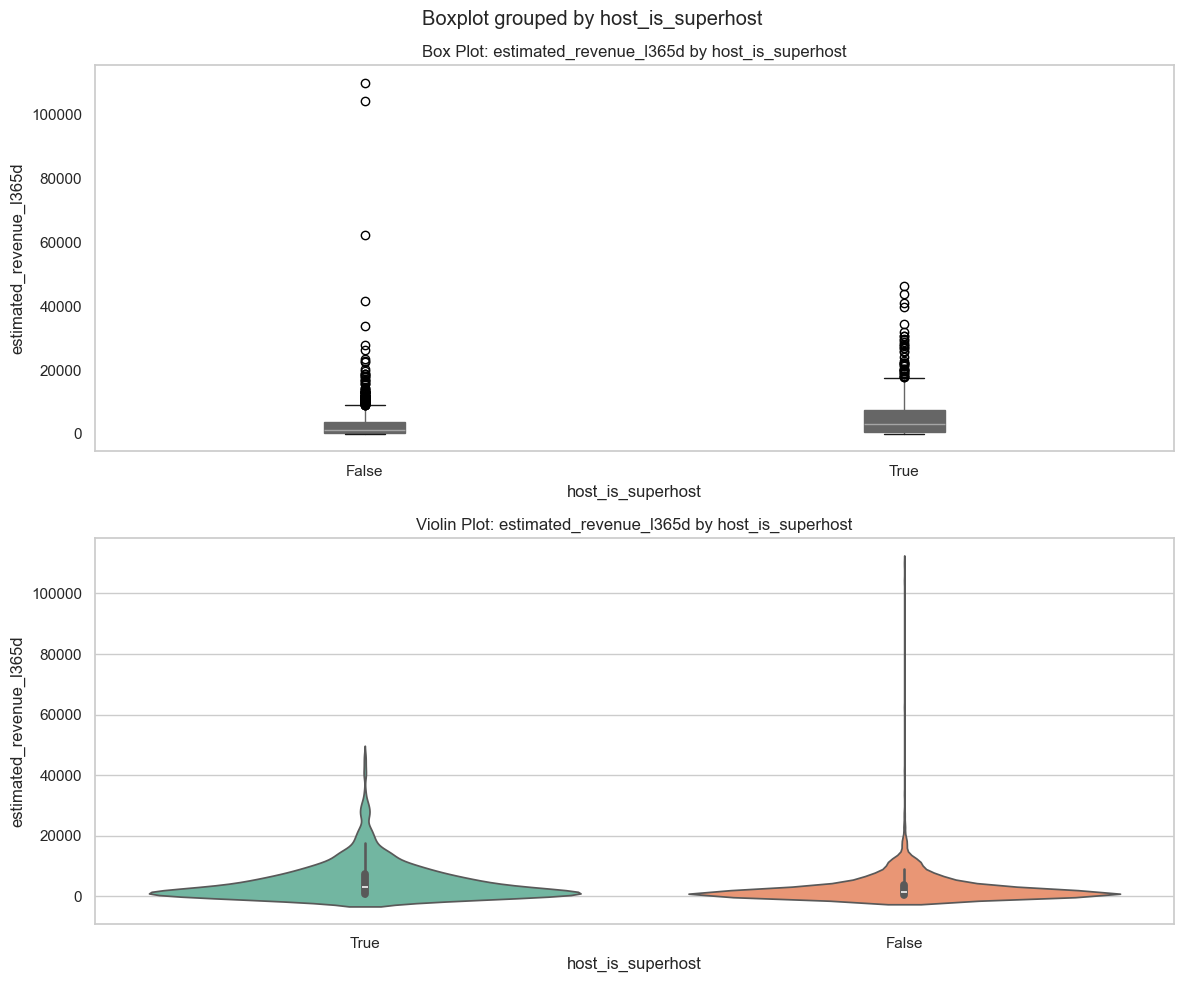

WELCH'S T-TEST: estimated_revenue_l365d by host_is_superhost

Descriptive Statistics by Group:

  host_is_superhost = True:
    N:      805
    Mean:   5150.4944
    Median: 3000.0000
    Std:    6423.6059
    Min:    0.0000
    Max:    46320.0000

  host_is_superhost = False:
    N:      1456
    Mean:   2986.1051
    Median: 1320.0000
    Std:    5705.6498
    Min:    0.0000
    Max:    109896.0000

Test Statistics:
  Test:                Welch's t-test
  Test statistic:      7.9771
  P-value:             0.000000
  Cohen's d:    0.362
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_is_superhost has a significant effect on estimated_revenue_l365d. Small effect (Cohen's d = 0.362).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    host_is_superhost = True: p=0.0000 (Non-normal)
    host_is_superhost = False: p=0.0000 (Non-normal)
  Homogeneity of variance (Levene's test): p=0.0000 (Unequal va

In [ ]:
analyze_categorical_numerical(df.loc[df["Host_Category"] == "Large Multi (4+)"]["host_is_superhost"], df["estimated_revenue_l365d"])

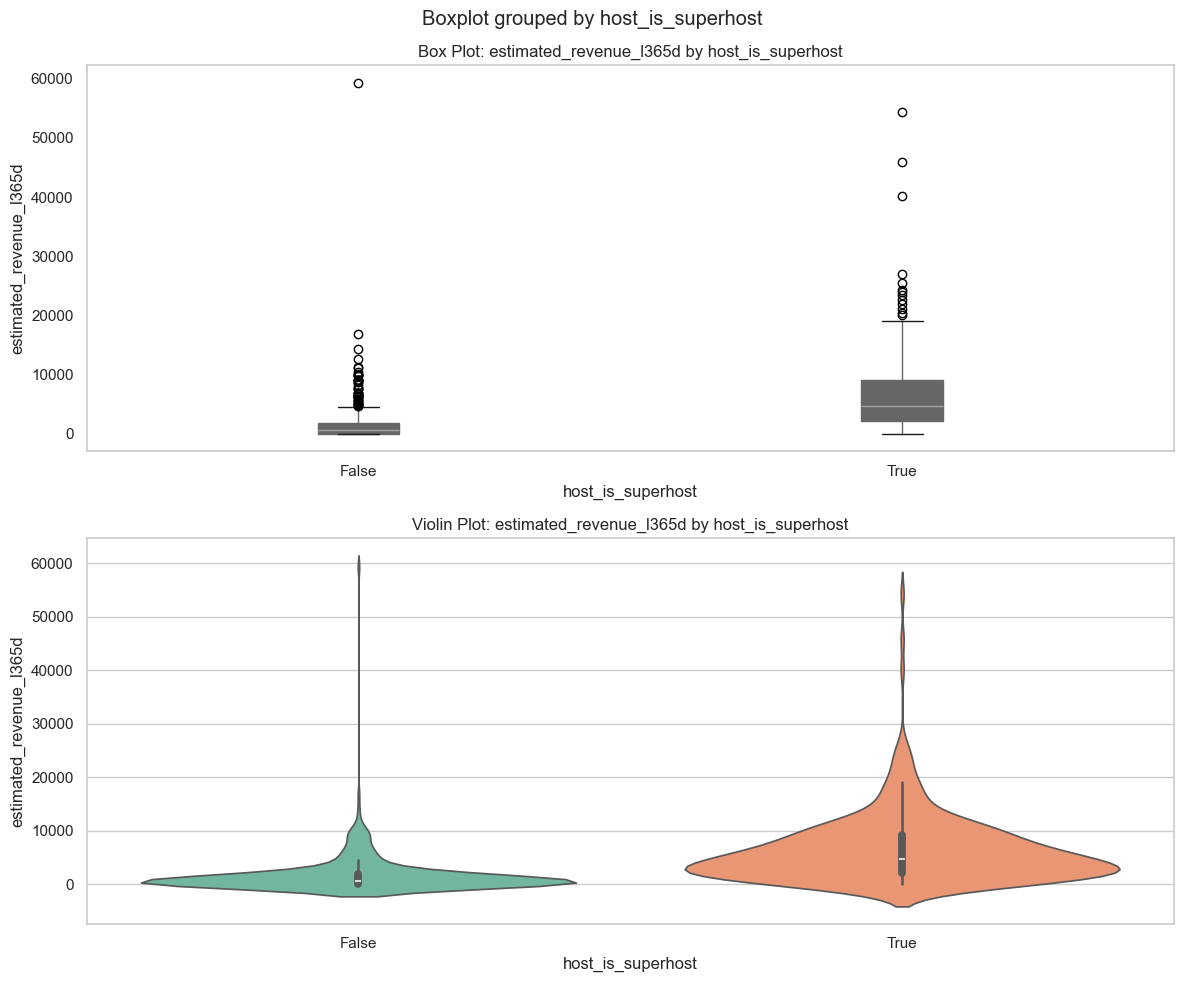

WELCH'S T-TEST: estimated_revenue_l365d by host_is_superhost

Descriptive Statistics by Group:

  host_is_superhost = False:
    N:      440
    Mean:   1763.7955
    Median: 684.0000
    Std:    3742.3798
    Min:    0.0000
    Max:    59280.0000

  host_is_superhost = True:
    N:      331
    Mean:   6534.6707
    Median: 4704.0000
    Std:    6542.5970
    Min:    0.0000
    Max:    54315.0000

Test Statistics:
  Test:                Welch's t-test
  Test statistic:      -11.8845
  P-value:             0.000000
  Cohen's d:    0.929
  Effect size:         Large effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_is_superhost has a significant effect on estimated_revenue_l365d. Large effect (Cohen's d = 0.929).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    host_is_superhost = False: p=0.0000 (Non-normal)
    host_is_superhost = True: p=0.0000 (Non-normal)
  Homogeneity of variance (Levene's test): p=0.0000 (Unequal var

In [ ]:
analyze_categorical_numerical(df.loc[df["Host_Category"] == "Small Multi (2-3)"]["host_is_superhost"], df["estimated_revenue_l365d"])

### statistical testing for base hypotheses

#### 2 - Superhost revenue multiplier

In [ ]:
from scipy import stats
from scipy.stats import chi2_contingency

print("\n" + "="*60)
print("TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)")
print("="*60)

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['Host_Category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['Host_Category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    t_stat, p_value = stats.ttest_ind(superhosts, non_superhosts)
    
    revenue_diff = superhosts.mean() - non_superhosts.mean()
    multiplier = superhosts.mean() / non_superhosts.mean() if non_superhosts.mean() > 0 else 0
    
    print(f"\n{category}:")
    print(f"  Revenue difference: €{revenue_diff:.2f} ({multiplier:.2f}x)")
    print(f"  t={t_stat:.3f}, p={p_value:.4f}, Significant: {p_value < 0.05}")


TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)

Individual (1):
  Revenue difference: €5280.45 (3.23x)
  t=18.724, p=0.0000, Significant: True

Small Multi (2-3):
  Revenue difference: €4538.08 (3.19x)
  t=11.253, p=0.0000, Significant: True

Large Multi (4+):
  Revenue difference: €2282.73 (1.65x)
  t=7.822, p=0.0000, Significant: True


In [ ]:
print("\n" + "="*60)
print("TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)")
print("="*60)

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df_good[(df_good['Host_Category'] == category) & 
                    (df_good['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df_good[(df_good['Host_Category'] == category) & 
                        (df_good['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    t_stat, p_value = stats.ttest_ind(superhosts, non_superhosts)
    
    revenue_diff = superhosts.mean() - non_superhosts.mean()
    multiplier = superhosts.mean() / non_superhosts.mean() if non_superhosts.mean() > 0 else 0
    
    print(f"\n{category}:")
    print(f"  Revenue difference: €{revenue_diff:.2f} ({multiplier:.2f}x)")
    print(f"  t={t_stat:.3f}, p={p_value:.4f}, Significant: {p_value < 0.05}")


TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)

Individual (1):
  Revenue difference: €5269.56 (3.21x)
  t=18.612, p=0.0000, Significant: True

Small Multi (2-3):
  Revenue difference: €4565.38 (3.21x)
  t=11.322, p=0.0000, Significant: True

Large Multi (4+):
  Revenue difference: €2281.20 (1.65x)
  t=7.798, p=0.0000, Significant: True


#### 4 - Review score diffences accross categories

In [ ]:
print("\n" + "="*60)
print("TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES")
print("="*60)

# Create aligned dataset - drop rows where either variable is NaN (same as analyze_categorical_numerical)
analysis_df = df[['Host_Category', 'review_scores_rating']].dropna()

rating_groups = []
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    ratings = analysis_df[analysis_df['Host_Category'] == category]['review_scores_rating']
    rating_groups.append(ratings)
    print(f"{category}: mean={ratings.mean():.3f}, std={ratings.std():.3f}, n={len(ratings)}")

f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES
Individual (1): mean=4.840, std=0.281, n=998
Small Multi (2-3): mean=4.808, std=0.334, n=765
Large Multi (4+): mean=4.641, std=0.457, n=2348

ANOVA Results: F=109.178, p-value=0.0000
Significant at α=0.05: True


In [ ]:
print("\n" + "="*60)
print("TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)")
print("="*60)

# Create contingency table
contingency_table = pd.crosstab(df['Host_Category'], df['host_is_superhost'])
print("\nContingency Table:")
print(contingency_table)

# Calculate percentages
superhost_rates = df.groupby('Host_Category')['host_is_superhost'].apply(
    lambda x: (x == True).sum() / len(x) * 100
)
print("\nSuperhost Rates:")
for category in superhost_rates.index:
    print(f"{category}: {superhost_rates[category]:.2f}%")

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square Results: χ²={chi2:.3f}, p-value={p_value:.4f}, df={dof}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)

Contingency Table:
host_is_superhost  False  True 
Host_Category                  
Individual (1)       614    388
Large Multi (4+)    1306    751
Small Multi (2-3)    394    344

Superhost Rates:
Individual (1): 38.68%
Large Multi (4+): 31.88%
Small Multi (2-3): 44.97%

Chi-square Results: χ²=23.355, p-value=0.0000, df=2
Significant at α=0.05: True


#### effect size - should tests be trusted?

In [ ]:

print("\n" + "="*60)
print("EFFECT SIZES (Cohen's d for revenue differences)")
print("="*60)

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['Host_Category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['Host_Category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    if len(superhosts) > 0 and len(non_superhosts) > 0:
        d = cohens_d(superhosts, non_superhosts)
        interpretation = "small" if abs(d) < 0.5 else "medium" if abs(d) < 0.8 else "large"
        print(f"{category}: d={d:.3f} ({interpretation} effect)")


EFFECT SIZES (Cohen's d for revenue differences)
Individual (1): d=1.247 (large effect)
Small Multi (2-3): d=0.852 (large effect)
Large Multi (4+): d=0.367 (small effect)


In [ ]:
# Helper function for two-way analysis
from scipy import stats
from itertools import product

def analyze_two_way(df, var_name, categories, display_name=None):
    """Analyze a numeric variable by host_cat and superhost status"""
    display_name = display_name or var_name
    
    print("="*70)
    print(f"TWO-WAY ANALYSIS: {display_name} by Host Category × Superhost Status")
    print("="*70)
    
    # Create summary table
    summary_data = []
    for cat in categories:
        for sh in [True, False]:
            data = df[(df['host_cat'] == cat) & (df['host_is_superhost'] == sh)][var_name].dropna()
            summary_data.append({
                'Host Category': cat,
                'Superhost': 'Yes' if sh else 'No',
                'N': len(data),
                'Mean': data.mean(),
                'Median': data.median(),
                'Std': data.std()
            })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nDescriptive Statistics:")
    print(summary_df.to_string(index=False))
    
    # Calculate superhost premium within each category
    print("\n" + "-"*70)
    print("SUPERHOST PREMIUM BY CATEGORY (Mann-Whitney U tests):")
    print("-"*70)
    
    for cat in categories:
        sh_data = df[(df['host_cat'] == cat) & (df['host_is_superhost'] == True)][var_name].dropna()
        non_sh_data = df[(df['host_cat'] == cat) & (df['host_is_superhost'] == False)][var_name].dropna()
        
        if len(sh_data) > 0 and len(non_sh_data) > 0:
            # Mann-Whitney U (non-parametric)
            u_stat, p_value = stats.mannwhitneyu(sh_data, non_sh_data, alternative='two-sided')
            
            # Effect size (rank-biserial correlation)
            n1, n2 = len(sh_data), len(non_sh_data)
            r = 1 - (2*u_stat) / (n1 * n2)  # rank-biserial correlation
            
            diff = sh_data.mean() - non_sh_data.mean()
            pct_diff = (diff / non_sh_data.mean() * 100) if non_sh_data.mean() != 0 else 0
            
            sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            
            print(f"\n{cat}:")
            print(f"  Superhost: {sh_data.mean():.2f} (n={len(sh_data)})")
            print(f"  Non-Superhost: {non_sh_data.mean():.2f} (n={len(non_sh_data)})")
            print(f"  Difference: {diff:+.2f} ({pct_diff:+.1f}%)")
            print(f"  Mann-Whitney U={u_stat:.0f}, p={p_value:.4f} {sig}")
            print(f"  Effect size (r): {r:.3f} ({'small' if abs(r) < 0.3 else 'medium' if abs(r) < 0.5 else 'large'})")
    
    return summary_df

TWO-WAY ANALYSIS: Listing Age (Years) by Host Category × Superhost Status

Descriptive Statistics:
      Host Category Superhost   N  Mean  Median  Std
     Individual (1)       Yes 388  3.32    2.14 2.65
     Individual (1)        No 614  2.75    1.75 2.71
  Small Multi (2-3)       Yes 344  3.14    2.23 2.56
  Small Multi (2-3)        No 394  3.16    2.02 2.88
Medium Multi (4-10)       Yes 327  3.27    2.64 2.47
Medium Multi (4-10)        No 397  2.93    2.03 2.48
  Large Multi (11+)       Yes 424  2.92    1.99 2.73
  Large Multi (11+)        No 909  2.10    1.52 1.92

----------------------------------------------------------------------
SUPERHOST PREMIUM BY CATEGORY (Mann-Whitney U tests):
----------------------------------------------------------------------

Individual (1):
  Superhost: 3.32 (n=388)
  Non-Superhost: 2.75 (n=614)
  Difference: +0.57 (+20.6%)
  Mann-Whitney U=141813, p=0.0000 ***
  Effect size (r): -0.191 (small)

Small Multi (2-3):
  Superhost: 3.14 (n=344)
  Non-S

TypeError: '<' not supported between instances of 'NoneType' and 'bool'

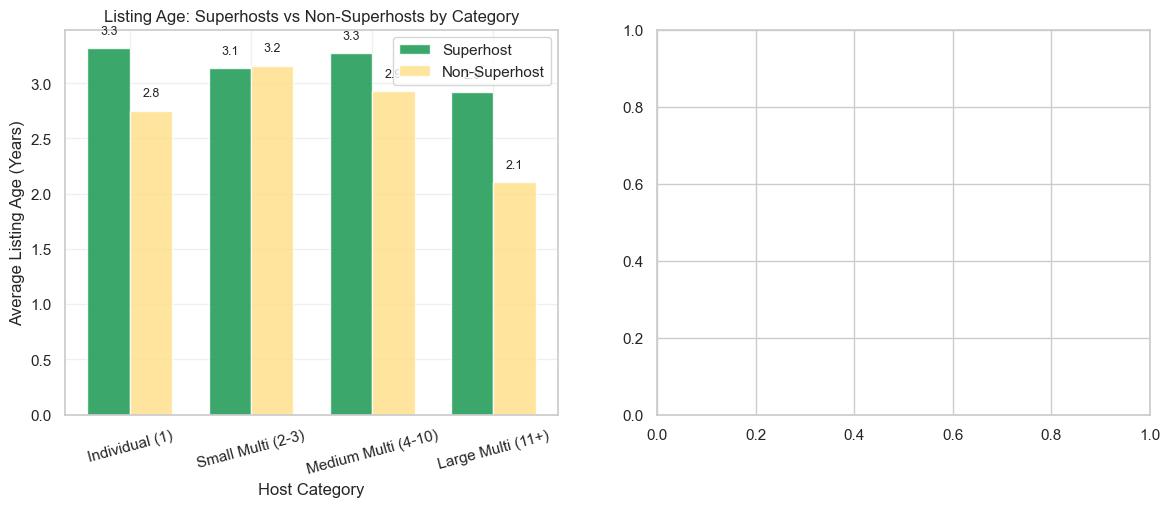

In [ ]:
# 1. LISTING AGE BY HOST CATEGORY × SUPERHOST STATUS
categories = ['Individual (1)', 'Small Multi (2-3)', 'Medium Multi (4-10)', 'Large Multi (11+)']

summary_age = analyze_two_way(df, 'listing_age_years', categories, 'Listing Age (Years)')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Grouped bar chart
x = np.arange(len(categories))
width = 0.35

means_sh = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == True)]['listing_age_years'].mean() 
            for cat in categories]
means_non = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == False)]['listing_age_years'].mean() 
             for cat in categories]

bars1 = axes[0].bar(x - width/2, means_sh, width, label='Superhost', color='#1a9850', alpha=0.85)
bars2 = axes[0].bar(x + width/2, means_non, width, label='Non-Superhost', color='#fee08b', alpha=0.85)

axes[0].set_xlabel('Host Category')
axes[0].set_ylabel('Average Listing Age (Years)')
axes[0].set_title('Listing Age: Superhosts vs Non-Superhosts by Category')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=15)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Right: Box plot
df_plot = df[df['host_cat'].isin(categories)].copy()
df_plot['Group'] = df_plot['host_cat'] + '\n' + df_plot['host_is_superhost'].map({True: 'SH', False: 'Non-SH'})

sns.boxplot(data=df_plot, x='host_cat', y='listing_age_years', hue='host_is_superhost',
            order=categories, palette={True: '#1a9850', False: '#fee08b'}, ax=axes[1])
axes[1].set_xlabel('Host Category')
axes[1].set_ylabel('Listing Age (Years)')
axes[1].set_title('Listing Age Distribution by Category × Superhost')
axes[1].legend(title='Superhost', labels=['No', 'Yes'])
axes[1].tick_params(axis='x', rotation=15)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

TWO-WAY ANALYSIS: Estimated Revenue (€/year) by Host Category × Superhost Status

Descriptive Statistics:
      Host Category Superhost   N     Mean   Median      Std
     Individual (1)       Yes 370 7,652.50 6,669.00 5,431.81
     Individual (1)        No 576 2,372.05 1,248.00 3,237.71
  Small Multi (2-3)       Yes 328 6,613.54 4,830.00 6,527.90
  Small Multi (2-3)        No 373 2,075.45   960.00 3,984.78
Medium Multi (4-10)       Yes 313 5,097.58 3,480.00 5,550.03
Medium Multi (4-10)        No 371 2,527.45 1,140.00 3,419.32
  Large Multi (11+)       Yes 402 6,332.20 4,362.00 7,175.72
  Large Multi (11+)        No 872 3,926.60 2,217.00 6,797.89

----------------------------------------------------------------------
SUPERHOST PREMIUM BY CATEGORY (Mann-Whitney U tests):
----------------------------------------------------------------------

Individual (1):
  Superhost: 7652.50 (n=370)
  Non-Superhost: 2372.05 (n=576)
  Difference: +5280.45 (+222.6%)
  Mann-Whitney U=183246, p=0.0000 **

TypeError: '<' not supported between instances of 'NoneType' and 'bool'

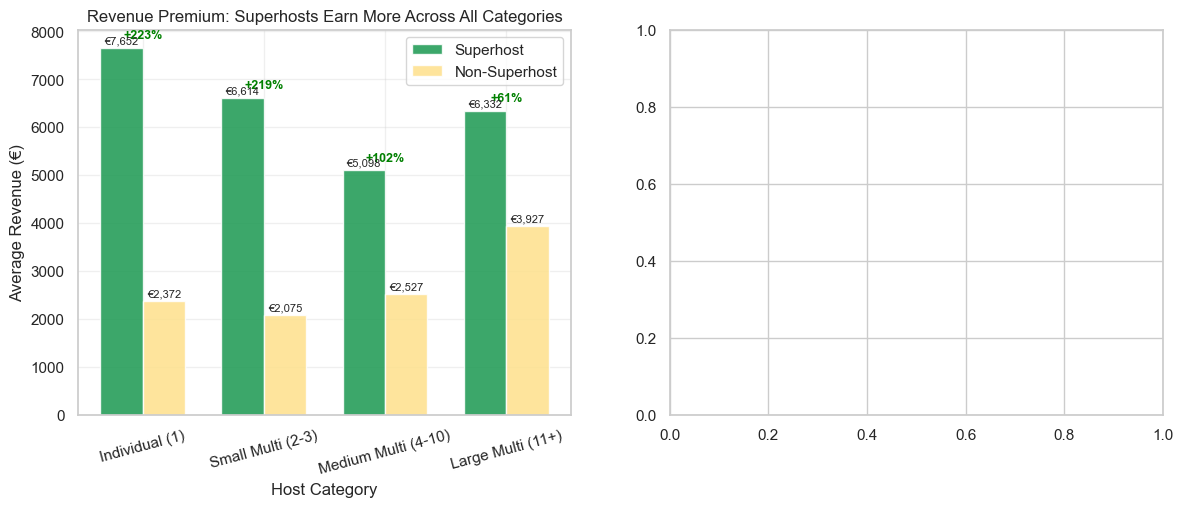

In [ ]:
# 2. ESTIMATED REVENUE BY HOST CATEGORY × SUPERHOST STATUS
summary_revenue = analyze_two_way(df, 'estimated_revenue_l365d', categories, 'Estimated Revenue (€/year)')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Grouped bar chart
means_sh = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].mean() 
            for cat in categories]
means_non = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].mean() 
             for cat in categories]

x = np.arange(len(categories))
bars1 = axes[0].bar(x - width/2, means_sh, width, label='Superhost', color='#1a9850', alpha=0.85)
bars2 = axes[0].bar(x + width/2, means_non, width, label='Non-Superhost', color='#fee08b', alpha=0.85)

axes[0].set_xlabel('Host Category')
axes[0].set_ylabel('Average Revenue (€)')
axes[0].set_title('Revenue Premium: Superhosts Earn More Across All Categories')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=15)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add value labels with percentage difference
for i, (sh, non) in enumerate(zip(means_sh, means_non)):
    pct = ((sh - non) / non * 100) if non > 0 else 0
    axes[0].text(x[i], max(sh, non) + 200, f'+{pct:.0f}%', ha='center', fontsize=9, fontweight='bold', color='green')

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                 f'€{bar.get_height():,.0f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                 f'€{bar.get_height():,.0f}', ha='center', va='bottom', fontsize=8)

# Right: Violin plot for distribution
sns.violinplot(data=df_plot, x='host_cat', y='estimated_revenue_l365d', hue='host_is_superhost',
               order=categories, palette={True: '#1a9850', False: '#fee08b'}, 
               split=True, ax=axes[1], cut=0)
axes[1].set_xlabel('Host Category')
axes[1].set_ylabel('Estimated Revenue (€)')
axes[1].set_title('Revenue Distribution: Superhost vs Non-Superhost')
axes[1].legend(title='Superhost', labels=['No', 'Yes'])
axes[1].tick_params(axis='x', rotation=15)
axes[1].set_ylim(0, df['estimated_revenue_l365d'].quantile(0.95))

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

TWO-WAY ANALYSIS: Review Score (Stars) by Host Category × Superhost Status

Descriptive Statistics:
      Host Category Superhost   N  Mean  Median  Std
     Individual (1)       Yes 388  4.91    4.92 0.08
     Individual (1)        No 614  4.79    4.89 0.35
  Small Multi (2-3)       Yes 344  4.89    4.92 0.11
  Small Multi (2-3)        No 394  4.73    4.83 0.43
Medium Multi (4-10)       Yes 327  4.88    4.90 0.15
Medium Multi (4-10)        No 397  4.68    4.76 0.40
  Large Multi (11+)       Yes 424  4.83    4.87 0.20
  Large Multi (11+)        No 909  4.42    4.53 0.57

----------------------------------------------------------------------
SUPERHOST PREMIUM BY CATEGORY (Mann-Whitney U tests):
----------------------------------------------------------------------

Individual (1):
  Superhost: 4.91 (n=388)
  Non-Superhost: 4.79 (n=614)
  Difference: +0.12 (+2.4%)
  Mann-Whitney U=128631, p=0.0303 *
  Effect size (r): -0.080 (small)

Small Multi (2-3):
  Superhost: 4.89 (n=344)
  Non-Sup

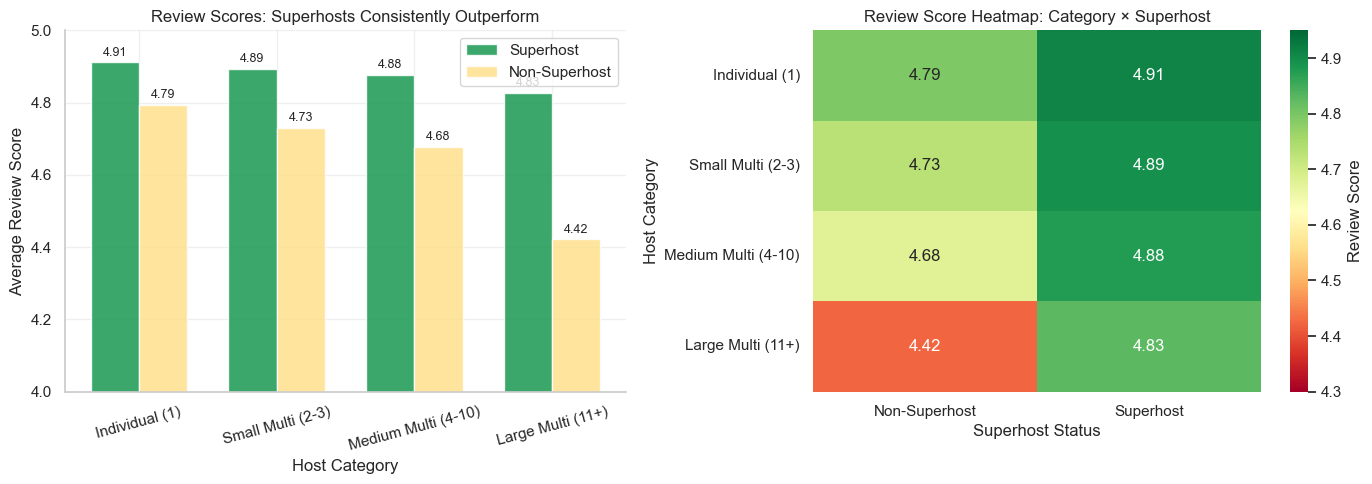

In [ ]:
# 3. REVIEW SCORES BY HOST CATEGORY × SUPERHOST STATUS
summary_rating = analyze_two_way(df, 'review_scores_rating', categories, 'Review Score (Stars)')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Grouped bar chart
means_sh = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == True)]['review_scores_rating'].mean() 
            for cat in categories]
means_non = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == False)]['review_scores_rating'].mean() 
             for cat in categories]

x = np.arange(len(categories))
bars1 = axes[0].bar(x - width/2, means_sh, width, label='Superhost', color='#1a9850', alpha=0.85)
bars2 = axes[0].bar(x + width/2, means_non, width, label='Non-Superhost', color='#fee08b', alpha=0.85)

axes[0].set_xlabel('Host Category')
axes[0].set_ylabel('Average Review Score')
axes[0].set_title('Review Scores: Superhosts Consistently Outperform')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=15)
axes[0].set_ylim(4.0, 5.0)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add value labels
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)

# Right: Heatmap of mean scores
pivot_data = df.pivot_table(values='review_scores_rating', 
                            index='host_cat', 
                            columns='host_is_superhost', 
                            aggfunc='mean')
pivot_data = pivot_data.reindex(categories)
pivot_data.columns = ['Non-Superhost', 'Superhost']

sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn', 
            vmin=4.3, vmax=4.95, ax=axes[1], cbar_kws={'label': 'Review Score'})
axes[1].set_title('Review Score Heatmap: Category × Superhost')
axes[1].set_xlabel('Superhost Status')
axes[1].set_ylabel('Host Category')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

TWO-WAY ANALYSIS: Acceptance Rate by Host Category × Superhost Status

Descriptive Statistics:
      Host Category Superhost   N  Mean  Median  Std
     Individual (1)       Yes 366  0.97    1.00 0.07
     Individual (1)        No 518  0.89    1.00 0.25
  Small Multi (2-3)       Yes 330  0.96    1.00 0.09
  Small Multi (2-3)        No 353  0.88    1.00 0.25
Medium Multi (4-10)       Yes 323  0.96    1.00 0.11
Medium Multi (4-10)        No 357  0.92    1.00 0.20
  Large Multi (11+)       Yes 411  1.00    1.00 0.01
  Large Multi (11+)        No 807  0.98    1.00 0.09

----------------------------------------------------------------------
SUPERHOST PREMIUM BY CATEGORY (Mann-Whitney U tests):
----------------------------------------------------------------------

Individual (1):
  Superhost: 0.97 (n=366)
  Non-Superhost: 0.89 (n=518)
  Difference: +0.08 (+8.6%)
  Mann-Whitney U=94542, p=0.9353 
  Effect size (r): 0.003 (small)

Small Multi (2-3):
  Superhost: 0.96 (n=330)
  Non-Superhost: 

TypeError: '<' not supported between instances of 'NoneType' and 'bool'

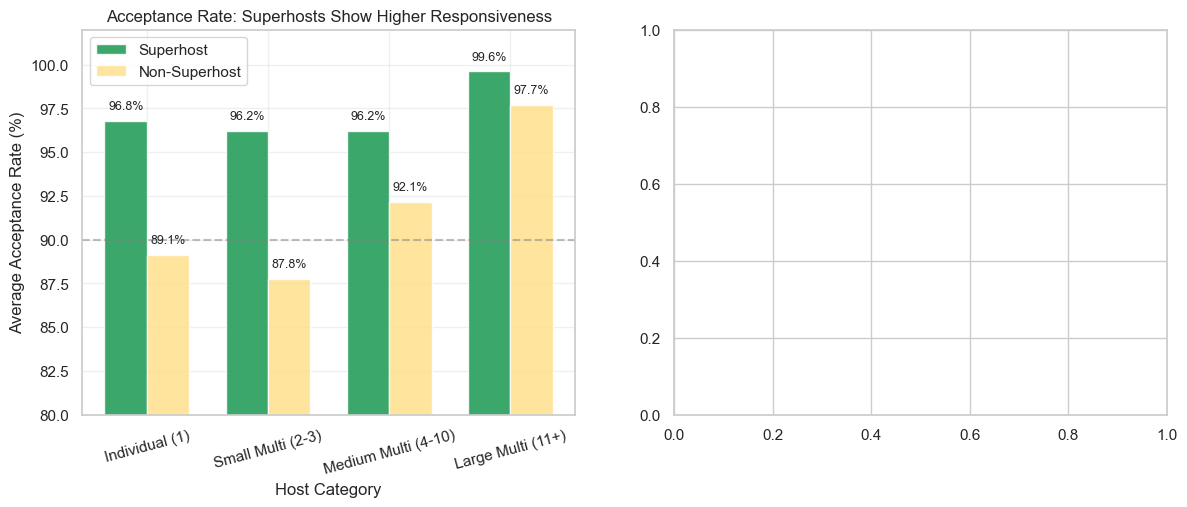

In [ ]:
# 4. ACCEPTANCE RATE BY HOST CATEGORY × SUPERHOST STATUS
summary_accept = analyze_two_way(df, 'host_acceptance_rate', categories, 'Acceptance Rate')

# Convert to percentage for display
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Grouped bar chart (converted to %)
means_sh = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == True)]['host_acceptance_rate'].mean() * 100
            for cat in categories]
means_non = [df[(df['host_cat'] == cat) & (df['host_is_superhost'] == False)]['host_acceptance_rate'].mean() * 100
             for cat in categories]

x = np.arange(len(categories))
bars1 = axes[0].bar(x - width/2, means_sh, width, label='Superhost', color='#1a9850', alpha=0.85)
bars2 = axes[0].bar(x + width/2, means_non, width, label='Non-Superhost', color='#fee08b', alpha=0.85)

axes[0].set_xlabel('Host Category')
axes[0].set_ylabel('Average Acceptance Rate (%)')
axes[0].set_title('Acceptance Rate: Superhosts Show Higher Responsiveness')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=15)
axes[0].set_ylim(80, 102)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')

# Add value labels
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                 f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                 f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

# Right: Box plot
sns.boxplot(data=df_plot, x='host_cat', y='host_acceptance_rate', hue='host_is_superhost',
            order=categories, palette={True: '#1a9850', False: '#fee08b'}, ax=axes[1])
axes[1].set_xlabel('Host Category')
axes[1].set_ylabel('Acceptance Rate')
axes[1].set_title('Acceptance Rate Distribution')
axes[1].legend(title='Superhost', labels=['No', 'Yes'])
axes[1].tick_params(axis='x', rotation=15)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# SUMMARY: Superhost Premium Across All Variables
print("="*80)
print("SUMMARY: SUPERHOST PREMIUM BY HOST CATEGORY")
print("="*80)

summary_rows = []
variables = [
    ('listing_age_years', 'Listing Age (yrs)'),
    ('estimated_revenue_l365d', 'Revenue (€)'),
    ('review_scores_rating', 'Review Score')
]

for var, display in variables:
    for cat in categories:
        sh = df[(df['host_cat'] == cat) & (df['host_is_superhost'] == True)][var].dropna()
        non_sh = df[(df['host_cat'] == cat) & (df['host_is_superhost'] == False)][var].dropna()
        
        if len(sh) > 0 and len(non_sh) > 0:
            diff = sh.mean() - non_sh.mean()
            pct = (diff / non_sh.mean() * 100) if non_sh.mean() != 0 else 0
            
            # Mann-Whitney U test and rank-biserial correlation (effect size)
            u_stat, p = stats.mannwhitneyu(sh, non_sh, alternative='two-sided')
            n1, n2 = len(sh), len(non_sh)
            r = 1 - (2*u_stat) / (n1 * n2)  # rank-biserial correlation
            
            # Interpret effect size
            if abs(r) < 0.1:
                effect_interp = "negligible"
            elif abs(r) < 0.3:
                effect_interp = "small"
            elif abs(r) < 0.5:
                effect_interp = "medium"
            else:
                effect_interp = "large"
            
            summary_rows.append({
                'Variable': display,
                'Category': cat,
                'Superhost Mean': round(sh.mean(), 2),
                'Non-SH Mean': round(non_sh.mean(), 2),
                'Difference': round(diff, 2),
                'Diff %': round(pct, 1),
                'p-value': round(p, 4),
                'Effect Size (r)': round(r, 3),
                'Effect': effect_interp
            })

summary_table = pd.DataFrame(summary_rows)
print(summary_table.to_string(index=False))

SUMMARY: SUPERHOST PREMIUM BY HOST CATEGORY
         Variable            Category  Superhost Mean  Non-SH Mean  Difference  Diff %  p-value  Effect Size (r)     Effect
Listing Age (yrs)      Individual (1)            3.32         2.75        0.57   20.60     0.00            -0.19      small
Listing Age (yrs)   Small Multi (2-3)            3.14         3.16       -0.02   -0.70     0.20            -0.05 negligible
Listing Age (yrs) Medium Multi (4-10)            3.27         2.93        0.34   11.60     0.04            -0.09 negligible
Listing Age (yrs)   Large Multi (11+)            2.92         2.10        0.82   38.80     0.00            -0.12      small
      Revenue (€)      Individual (1)        7,652.50     2,372.05    5,280.45  222.60     0.00            -0.72      large
      Revenue (€)   Small Multi (2-3)        6,613.54     2,075.45    4,538.08  218.70     0.00            -0.63      large
      Revenue (€) Medium Multi (4-10)        5,097.58     2,527.45    2,570.12  101.70  

The Professionalization Paradox
Large multi-listing operators (11+ properties) represent Thessaloniki's newest market entrants (median 1.6 years vs. 2.4 years for individuals), suggesting a recent wave of commercial investment in the STR sector. However, this rapid scaling has come at a measurable cost to guest experience.

The data reveals a troubling pattern:

Lowest Quality Floor: Non-superhost large operators deliver the worst guest experience in the market (4.42★), a full 0.37 stars below individual non-superhosts. This isn't statistical noise—it represents a large effect size (r=-0.60).

Diminished Returns on Quality: While superhost status delivers a 3.2x revenue multiplier for individual hosts (€5,280/year premium), large operators see only a 1.7x multiplier (€2,400/year). Quality investment is less rewarded at scale—perhaps because guests already expect professionalism from commercial operators.

Volume Over Excellence: With the lowest superhost rate (32%) despite controlling 38% of listings, large operators appear to prioritize portfolio expansion over guest satisfaction. The market is rewarding this strategy with marginally higher occupancy (78 vs. 75 days), but at what cost?

Is This Bad for the Market?
Yes, for several reasons:

Guest Experience Degradation: The 4.42★ floor from large non-SH operators drags down Thessaloniki's overall destination quality
Unfair Competition: Individual hosts who invest in superhost status earn 3x more, but compete against commercial operators who achieve acceptable returns with lower quality
Sustainability Risk: Young listings with poor reviews have higher churn risk—if these operators exit, it could destabilize neighborhoods with high concentrations
Tourism Reputation: Visitors who experience these lower-quality properties may not distinguish between "bad operator" and "bad destination"

Policy Recommendation Framework
Based on your findings, I'd suggest framing recommendations around:

1. Quality Incentives for Scale
Tie licensing renewal to minimum review thresholds (e.g., 4.5★)
Progressive requirements: 1-3 listings = baseline, 4-10 = enhanced, 11+ = premium standards
2. Superhost Recognition
Tourism authority could publicly highlight superhosts
Create a "quality tier" system for tourist-facing marketing
3. Market Monitoring
Track the quality trajectory of new large operators
Flag hosts with rapid expansion + declining reviews

The Sweet Spot of Scale"

Our analysis suggests that Thessaloniki's STR market performs optimally in the small-to-medium host segment (2-10 listings). These operators achieve:

The highest superhost rates (45-47%)
Strong revenue performance
Quality scores comparable to individual hosts
Large commercial operators (11+ listings), while contributing to market supply, show evidence of a "volume over quality" approach that may undermine destination reputation. Their youngest listings, lowest superhost rates, and significantly lower non-superhost review scores (4.42★) suggest rapid, quality-agnostic expansion.

For policymakers, the message is clear: Host diversity matters. Policies that encourage mid-scale professionalization while maintaining quality standards will better serve Thessaloniki's tourism ecosystem than unchecked commercial consolidation.